## Seattle Airbnb Open Data Analysis
#### Business Problem: Drive booking rate for groups of hosts whose listings have exceptionally low monthly booking rate.
#### Solution: Identify well-performing hosts and contributing attributes of this poor performing group that lead to significant improvements in their listings' monthly booking rates, recommend poor to mediocre hosts of this subgroup to carry out actions to obtain such attributes in their listings.

#### Exploratory Data Analysis: 
Hosts are grouped by have consistently seen high duration difference between the date they joined Airbnb and the last scraped date of their resepective listings, hosts are binned into years of 1 with the exception of >= 5 years.   (booking rates for all months are above median, belong to q3 and q4: upper half amongst listings)
1. Identify the group of hosts that have the lowest monthly booking rate
2. Perform further faceted analysis on this subgroup
3. Feature engineering on listings' features (deriving binary variables for presence of transit text, extracting sentiment scores of text variables)
4. Identify listings from the lowest monthly booking rate group that have consistently seen low monthly booking rates (booking rates for all months are below or equal to median, belong to q1 and q2: lower half amongst listings)
5. Identify listings from the lowest monthly booking rate group that have consistently seen high monthly booking rates, these hosts are deemed as the top performing hosts of the subgroup (booking rates for all months are above median, belong to q3 and q4: upper half amongst listings)
6. Perform comparative analysis on these two subgroups (from fourth step and fifth step) to identify their key differences on existing features and engineered features

#### Classification: 
#### Given set of attributes of a listing, predict the listing's booking rate quartile performance for the month (Q1, Q2, Q3 or Q4). 
#### If it is lower than the median booking rate (Q1 and Q2), remedy steps will be provided to the host to improve on his/her listing.
1. Select all relevant attributes
2. Perform encoding of categorical features and standardisation of numerical features
2. Feature selection using Lasso
3. Train-val-test split
4. Modeling
5. Evaluation

## Part I: Imports, loading data, basic checks and simple data cleaning

Import required libraries

In [14]:
import warnings
warnings.filterwarnings('ignore')

# Data manipulation libraries
import numpy as np
import pandas as pd
from scipy.stats import trim_mean

# Plotting libraries
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# NLP libraries
import spacy
from afinn import Afinn

# For POS and NER tag counting
from collections import Counter

# Preprocessing, modeling libraries
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score

In [2]:
# Set matplotlib inline visualisation display and default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (25.0, 15.0)
RANDOM_SEED = 15

Load datasets

In [3]:
calendar = pd.read_csv('data/calendar.csv')
listings = pd.read_csv('data/listings.csv')
reviews = pd.read_csv('data/reviews.csv')

### Basic scanning of datasets to check for adnormalities and null values

#### Calendar dataset

In [4]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [5]:
calendar.describe()

,listing_id
count,1.393570e+06
mean,5.550111e+06
std,2.962274e+06
min,3.335000e+03
25%,3.258213e+06
50%,6.118244e+06
75%,8.035212e+06
max,1.034016e+07


In [6]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [7]:
# check number of nulls
print('Number of nulls\n', calendar.isna().sum(), '\n')
# check percentage of nulls
print('Percentage of nulls\n', calendar.isna().sum()/calendar.count())

Number of nulls
 listing_id         0
date               0
available          0
price         459028
dtype: int64 

Percentage of nulls
 listing_id    0.00000
date          0.00000
available     0.00000
price         0.49118
dtype: float64


#### Listings dataset

In [8]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [9]:
listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,...,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,...,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,...,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,...,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,...,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,...,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


In [10]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

In [11]:
# check number of nulls
print('Number of nulls\n', listings.isna().sum(), '\n')
# check percentage of nulls
print('\nPercentage of nulls\n', listings.isna().sum()/listings.count())

Number of nulls
 id                                     0
listing_url                            0
scrape_id                              0
last_scraped                           0
name                                   0
summary                              177
space                                569
description                            0
experiences_offered                    0
neighborhood_overview               1032
notes                               1606
transit                              934
thumbnail_url                        320
medium_url                           320
picture_url                            0
xl_picture_url                       320
host_id                                0
host_url                               0
host_name                              2
host_since                             2
host_location                          8
host_about                           859
host_response_time                   523
host_response_rate                   523

#### Reviews dataset

In [12]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [13]:
reviews.describe()

,listing_id,id,reviewer_id
count,8.484900e+04,8.484900e+04,8.484900e+04
mean,3.005067e+06,3.058765e+07,1.701301e+07
std,2.472877e+06,1.636613e+07,1.353704e+07
min,4.291000e+03,3.721000e+03,1.500000e+01
25%,7.946330e+05,1.725127e+07,5.053141e+06
50%,2.488228e+06,3.228809e+07,1.413476e+07
75%,4.694479e+06,4.457648e+07,2.762402e+07
max,1.024814e+07,5.873651e+07,5.281274e+07


In [14]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null object
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


In [15]:
# check number of nulls
print('Number of nulls\n', reviews.isna().sum(), '\n')
# check percentage of nulls
print('\nPercentage of nulls\n', reviews.isna().sum()/reviews.count())

Number of nulls
 listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         18
dtype: int64 


Percentage of nulls
 listing_id       0.000000
id               0.000000
date             0.000000
reviewer_id      0.000000
reviewer_name    0.000000
comments         0.000212
dtype: float64


### Cleaning of date attributes for datasets and removing duplicates

In [3]:
listings_numerical = ['host_listings_count', 'host_total_listings_count', 'accommodates','bathrooms', 
                      'bedrooms', 'beds', 'guests_included', 'minimum_nights','maximum_nights', 
                      'availability_30','availability_60', 'availability_90', 'availability_365',
                      'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
                      'review_scores_communication', 'review_scores_location', 'review_scores_value', 
                      'calculated_host_listings_count', 'reviews_per_month']

listings_currency = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 
                     'cleaning_fee','extra_people']

# fill na with 'N/A' strings
fill_na_strings_cols = ['host_response_time', 'host_response_rate', 'host_acceptance_rate']

# fill na with 1
fill_na_1_cols = ['bathrooms', 'bedrooms', 'beds']

# fill na with 0
fill_na_0_cols = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                  'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
                  'review_scores_value', 'security_deposit', 'cleaning_fee']

convert_binary_features_url = ['thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url']

convert_binary_features_tf = ['host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 
                              'instant_bookable', 'require_guest_profile_picture',
                              'require_guest_phone_verification']

In [17]:
# set all dates to pandas datetime64
calendar['date'] = pd.to_datetime(calendar['date'])
listings['last_scraped'] = pd.to_datetime(listings['last_scraped'])
listings['host_since'] = pd.to_datetime(listings['host_since'])
reviews['date'] = pd.to_datetime(reviews['date'])

# set all values to float
listings[listings_numerical] = listings[listings_numerical].astype(float, copy=False)

# set currency values to float
listings[listings_currency] = listings[listings_currency].replace('[\$,]', '', regex=True).astype(float, copy=False)

listings[fill_na_strings_cols] = listings[fill_na_strings_cols].fillna('N/A')
listings[fill_na_1_cols] = listings[fill_na_1_cols].fillna(1)
listings[fill_na_0_cols] = listings[fill_na_0_cols].fillna(0)
listings['property_type'] = listings['property_type'].fillna('House')

# convert features to binary
for feature in convert_binary_features_url:
    listings[f'{feature}_exist'] = listings[feature].apply(lambda url: 1 if pd.notna(url) else 0)

for feature in convert_binary_features_tf:
    listings[f'{feature}_1'] = listings[feature].apply(lambda boolean: 1 if boolean == 't' else 0)

# drop duplicates for all 3 datasets
calendar.drop_duplicates(keep='first', inplace=True)
listings.drop_duplicates(keep='first', inplace=True)
reviews.drop_duplicates(keep='first', inplace=True)

## Part II: Exploratory Data Analysis

### Exploring Monthly Booking Rate variation of different listings faceted by distinct features

In [18]:
print(f'There is {listings.last_scraped.nunique()} unique value(s) for variable last_scraped in the listings dataset, the unique value(s) is/are: {listings.last_scraped.unique()[0].astype(str)}')

There is 1 unique value(s) for variable last_scraped in the listings dataset, the unique value(s) is/are: 2016-01-04T00:00:00.000000000


In [19]:
# extracting out month and year for grouping by
calendar['year'] = calendar['date'].apply(lambda date: date.year)
calendar['month'] = calendar['date'].apply(lambda date: date.month)

In [20]:
# group by listing id, year and month and availability
monthly_availability = calendar.drop(['price'], axis=1).groupby(['listing_id', 'year', 'month', 'available']).count().rename({'date': 'availability_days'}, axis=1)
monthly_availability.head()

availability_days
listing_id year month available                   
3335       2016 1     f                         28
                2     f                         28
                      t                          1
                3     t                         31
                4     t                         30

In [21]:
# obtain percentage of availability by listing id, year and month
monthly_availability_percent = monthly_availability.groupby(level=[0, 1, 2]).apply(lambda g: 
                                                                                   g / g.sum()).rename({'availability_days': 'availability_percentage'}, axis=1).unstack(level=-1)
monthly_availability_percent.head()

availability_percentage          
available                                   f         t
listing_id year month                                  
3335       2016 1                    1.000000       NaN
                2                    0.965517  0.034483
                3                         NaN  1.000000
                4                         NaN  1.000000
                5                         NaN  1.000000

In [22]:
# obtain monthly booking rate for listings
monthly_booking_rate = pd.DataFrame(monthly_availability_percent.apply(lambda row: row.availability_percentage.f 
                                                                       if not np.isnan(row.availability_percentage.f) 
                                                                       else 1-row.availability_percentage.t, axis=1)).stack().reset_index().drop('level_3', axis=1).rename({0: 'booking_rate'}, axis=1)
monthly_booking_rate.head()

,listing_id,year,month,booking_rate
0,3335,2016,1,1.000000
1,3335,2016,2,0.965517
2,3335,2016,3,0.000000
3,3335,2016,4,0.000000
4,3335,2016,5,0.000000


Text(0.5, 0.98, 'Distribution plots of Monthly Booking Rates by Months')

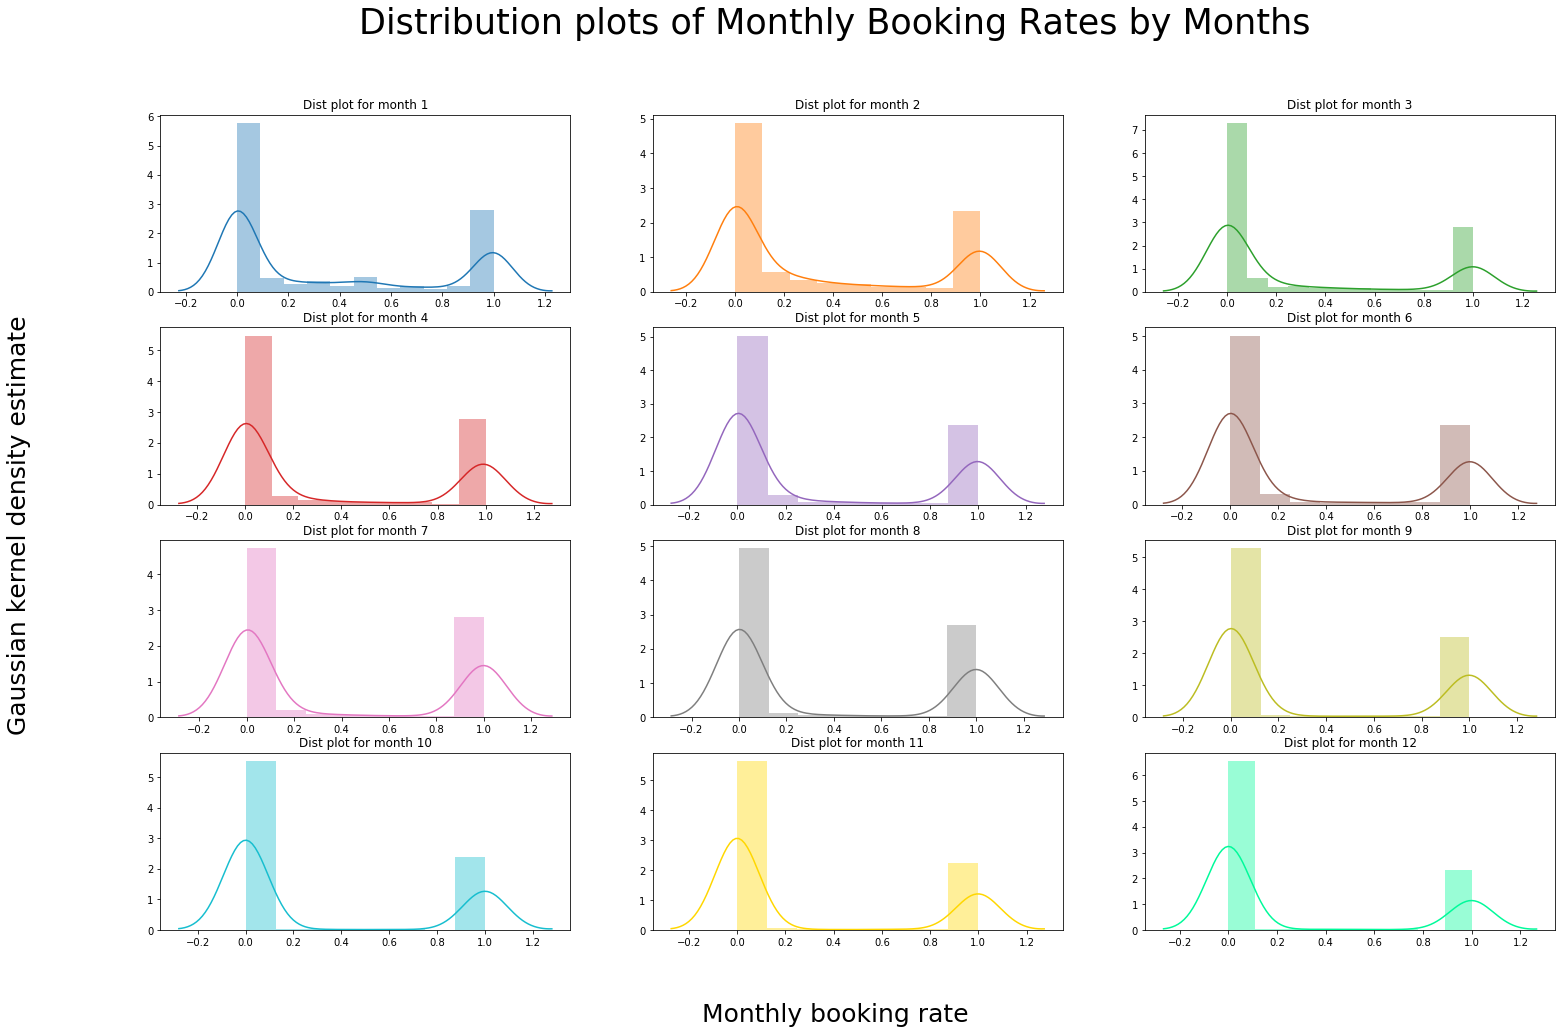

In [23]:
fig, axes = plt.subplots(4, 3)
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:grey', 'tab:olive', 'tab:cyan', 'gold', 'mediumspringgreen']

for index, colour in enumerate(colours):
    sns.distplot(monthly_booking_rate[monthly_booking_rate['month'] == index+1]['booking_rate'], ax=axes[int(index/3),int(index%3)], color=colour, axlabel='', kde=True).set_title(f'Dist plot for month {index+1}')

fig.text(0.5, 0.04, 'Monthly booking rate', ha='center', fontsize=25)
fig.text(0.04, 0.5, 'Gaussian kernel density estimate', va='center', rotation='vertical', fontsize=25)
fig.suptitle('Distribution plots of Monthly Booking Rates by Months', fontsize=35)

Analysis:<br>

Highly similiar bi-modal distribution observed for all distribution plots. This is an indication that majority of the listings either have zero or near zero booking rate or have nearly maximum booking rate at 1.0. It is only observed in the earlier months of the year (January and February) that there are a noticeable portion of listings spreading between 0.0 and 1.0 monthly booking rate.

In [24]:
# simple helper function for EDA with option for trimmed mean to account for outliers
# e.g. trim_proportion = 0.05 means trim values that are less and equal to 5th percentile value and values that are greater or equal to 95th percentile value
# default to trim 0.05
def booking_rate_filter(monthly_booking_rate_df, listings_df, listings_filter_var, average_months=True, trim_proportion=0.05, joined_df_only=False):
    if monthly_booking_rate_df is not None:
        filtered_listings_df = listings_df[['id', listings_filter_var]]
        joined_df = monthly_booking_rate_df.join(filtered_listings_df.set_index('id'), on='listing_id', how='inner')
    else:
        joined_df = listings_df
    if joined_df_only:
        return_df = joined_df
    else:
        if average_months:
            if trim_proportion:
                lower_quantile = joined_df['booking_rate'].quantile(trim_proportion)
                upper_quantile = joined_df['booking_rate'].quantile(1-trim_proportion)
                joined_df = joined_df[(joined_df['booking_rate'] > lower_quantile) & (joined_df['booking_rate'] < upper_quantile)]
            return_df = joined_df.groupby([listings_filter_var]).mean().drop(['listing_id', 'year', 'month'], axis=1).rename({'booking_rate': 'average_monthly_booking_rate'}, axis=1)
        else:
            if trim_proportion:
                lower_quantile = joined_df.groupby(['month']).quantile(trim_proportion, axis=0)['booking_rate']
                upper_quantile = joined_df.groupby(['month']).quantile(1-trim_proportion, axis=0)['booking_rate']
                joined_df['lower_quantile'] = joined_df.apply(lambda row: lower_quantile[row.month], axis=1)
                joined_df['upper_quantile'] = joined_df.apply(lambda row: upper_quantile[row.month], axis=1)
                joined_df = joined_df[(joined_df.booking_rate > joined_df['lower_quantile']) & (joined_df.booking_rate < joined_df['upper_quantile'])].drop(['lower_quantile', 'upper_quantile'], axis=1)
            return_df = joined_df.groupby([listings_filter_var, 'month']).mean().drop(['listing_id', 'year'], axis=1).rename({'booking_rate': 'monthly_booking_rate'}, axis=1)
    return return_df 

In [25]:
# data manipulation to bin years of hosting on airbnb (host_since) into distinct categories

# helper function for binning datetime
one_year = pd.Timedelta('365 days')
def airbnb_age(listings_row):
    if listings_row.host_since == pd.NaT or listings_row.last_scraped == pd.NaT:
        val = 'Missing one datetime value'
    else:
        airbnb_age_days = listings_row.last_scraped - listings_row.host_since
        if airbnb_age_days < one_year:
            val = '< 1 year'
        elif airbnb_age_days < one_year*2:
            val = '1 year <= & < 2 years'
        elif airbnb_age_days < one_year*3:
            val = '2 years <= & < 3 years'
        elif airbnb_age_days < one_year*4:
            val = '3 years <= & < 4 years'
        elif airbnb_age_days < one_year*5:
            val = '4 years <= & < 5 years'
        else:
            val = '>= 5 years'
    return val

# create column
listings['airbnb_age'] = listings.apply(airbnb_age, axis=1)

#### Visualisation: Monthly Booking Rate by Host Airbnb Age  (Mean)

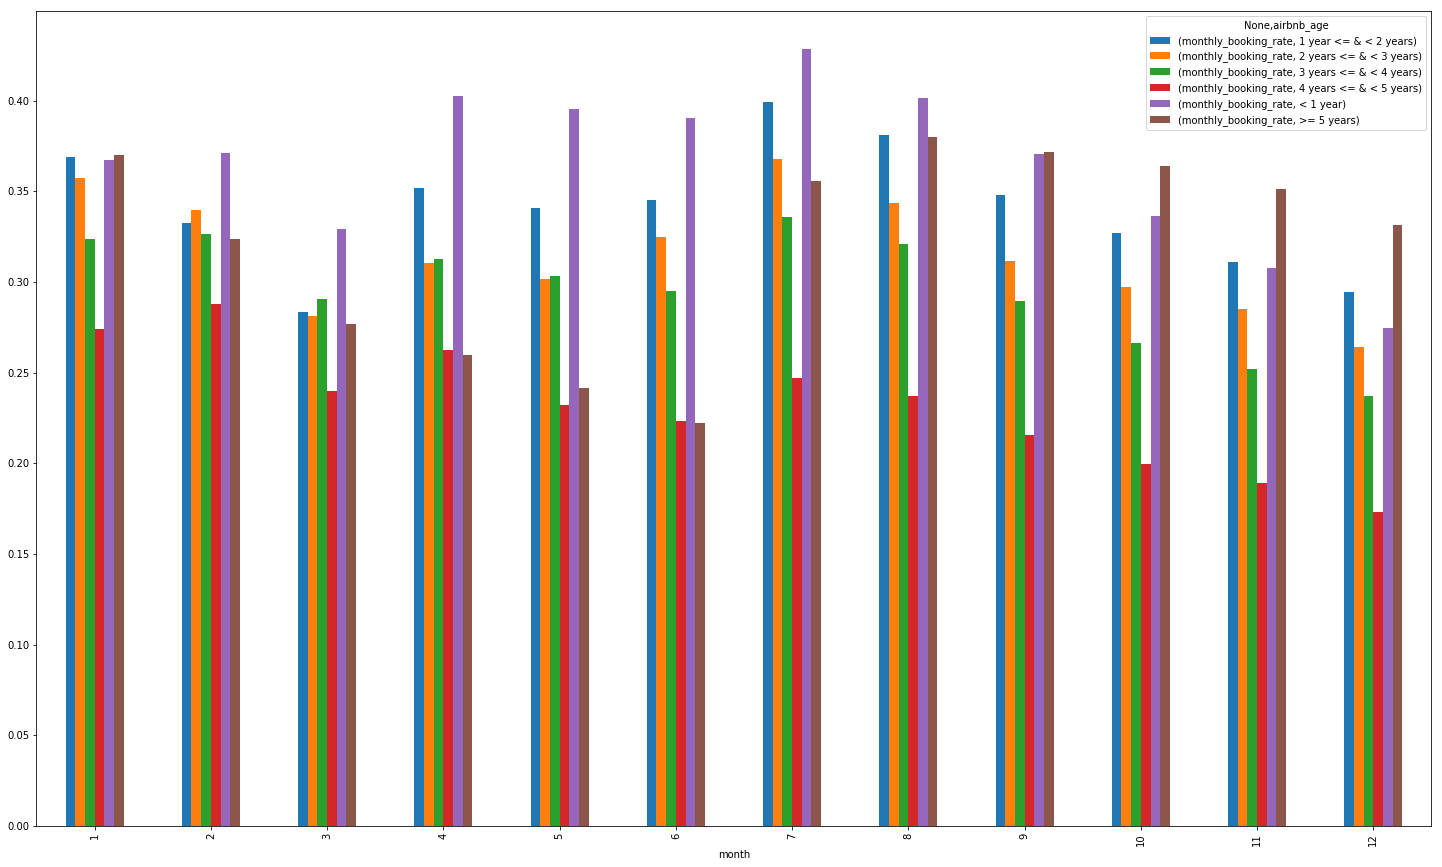

In [26]:
booking_rate_filter(monthly_booking_rate, listings, 'airbnb_age', average_months=False, trim_proportion=None).unstack(0).plot(kind='bar')

Analysis: <br>

As observed from the above visualisation, the monthly booking rate for hosts by their airbnb age is shown. <br>

Hosts with 4 years or more but less than 5 years of hosting experience have the lowest monthly booking rate amongst all age groups and for all months. The lowest monthly booking rate can be observed in December as this host group have a monthly booking rate of approximately 17% with the next lowest group (host with 3 years but less than 4 yeasr hosting experience) being at least 25% higher in monthly booking rate.<br>

Hosts with less than 1 year of hosting experience are observed to have the highest monthly booking rate as it is likely attributed from customers attraction to the novelty of new hosts' listings. Furthermore, it is an indicator that customers do steer from hosts with lesser experience on Airbnb. <br>

However, this is calculated using arithmetic mean and is prone to be influenced heavily to outliers, therefore the next visualisation will be showcasing trimmed mean.

#### Visualisation: Monthly Booking Rate by Host Airbnb Age  (Trimmed Mean, Trimmed 5th and 95th percentile values and lesser/greater respectively)

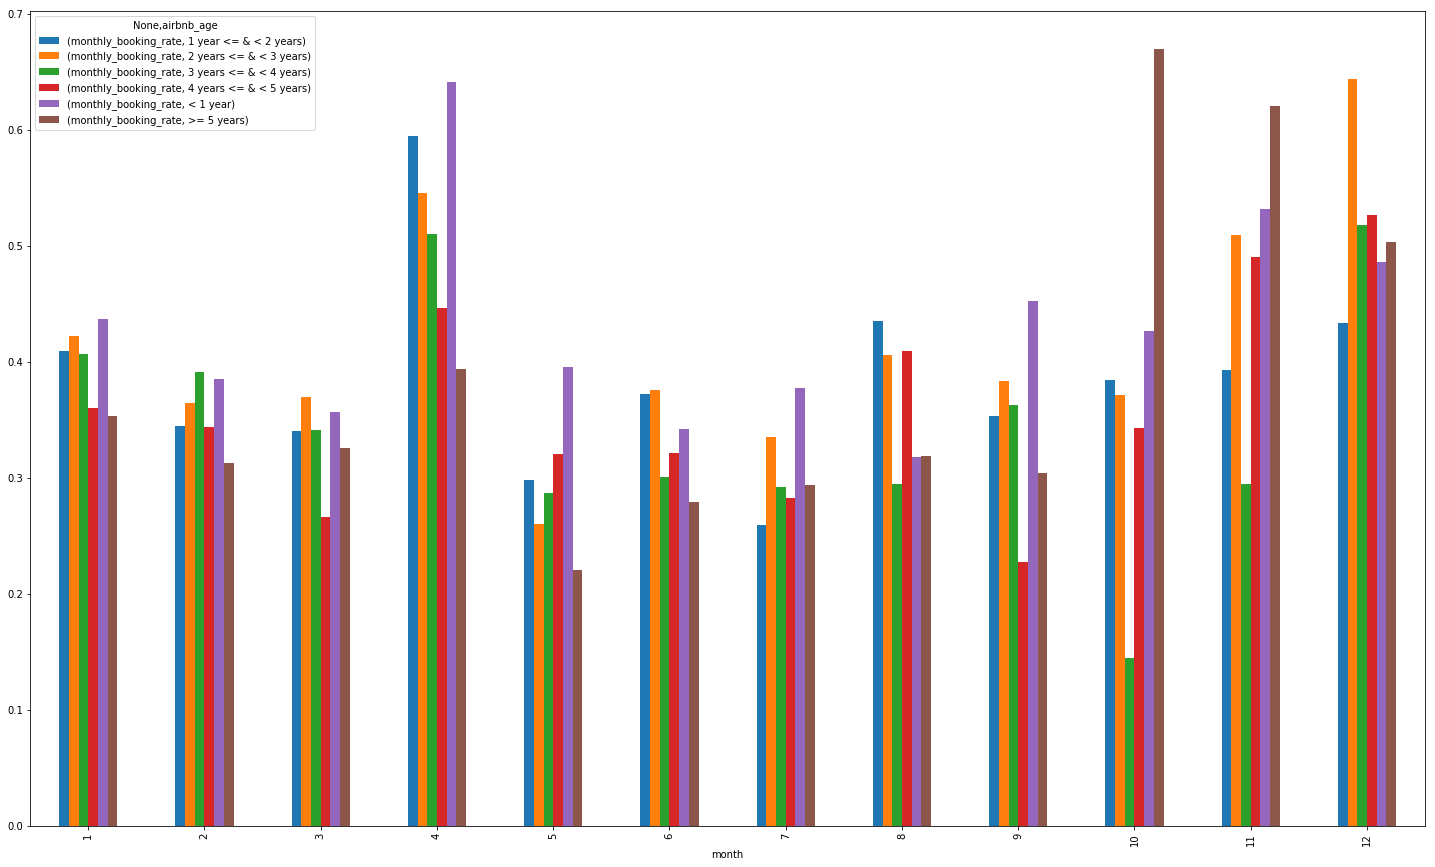

In [27]:
booking_rate_filter(monthly_booking_rate, listings, 'airbnb_age', average_months=False).unstack(0).plot(kind='bar')

Analysis: <br>

Stark constrasts can be observed by comparing the above visualisation to the visualisation with arithmetic mean. Hosts with 3-4 years hosting experience have became the worst performing hosts by trimmed mean monthly booking rate for the months 8, 11, 12 (August, Novemeber and December). <br>

By excluding fully booked and fully unbooked listings for the months, it can be observed that the months 4 (April) and 12 (December) are the peak periods for mediocre performing listings as the average amongst hosts are the highest in respect to the months. <br>

**As hosts with 4-5 years hosting experience (showed in the chart as red bars) are still performing relatively weak as observed from the majority of the months being the last or second-to-last in terms of monthly booking rate performance. Therefore, it is chosen as a group to conduct further analysis on.**

In [28]:
# filter listings to listings of hosts where hosting experience [4 years, 5 years)
four_years_host_listings = listings[listings['airbnb_age'] == '4 years <= & < 5 years']

Number of unique hosts in this group is 221
Number of unique listings in this group is 399
Average (Arithmetic Mean) number of listings per host is 1.81
Average (Trimmed Mean, 0.05 Cut) number of listings per host is 1.28
Average (Median) number of listings per host is 1.0
Average (Mode) number of listings per host is 1.0


Text(0.5, 0, 'Number of listings for hosts')

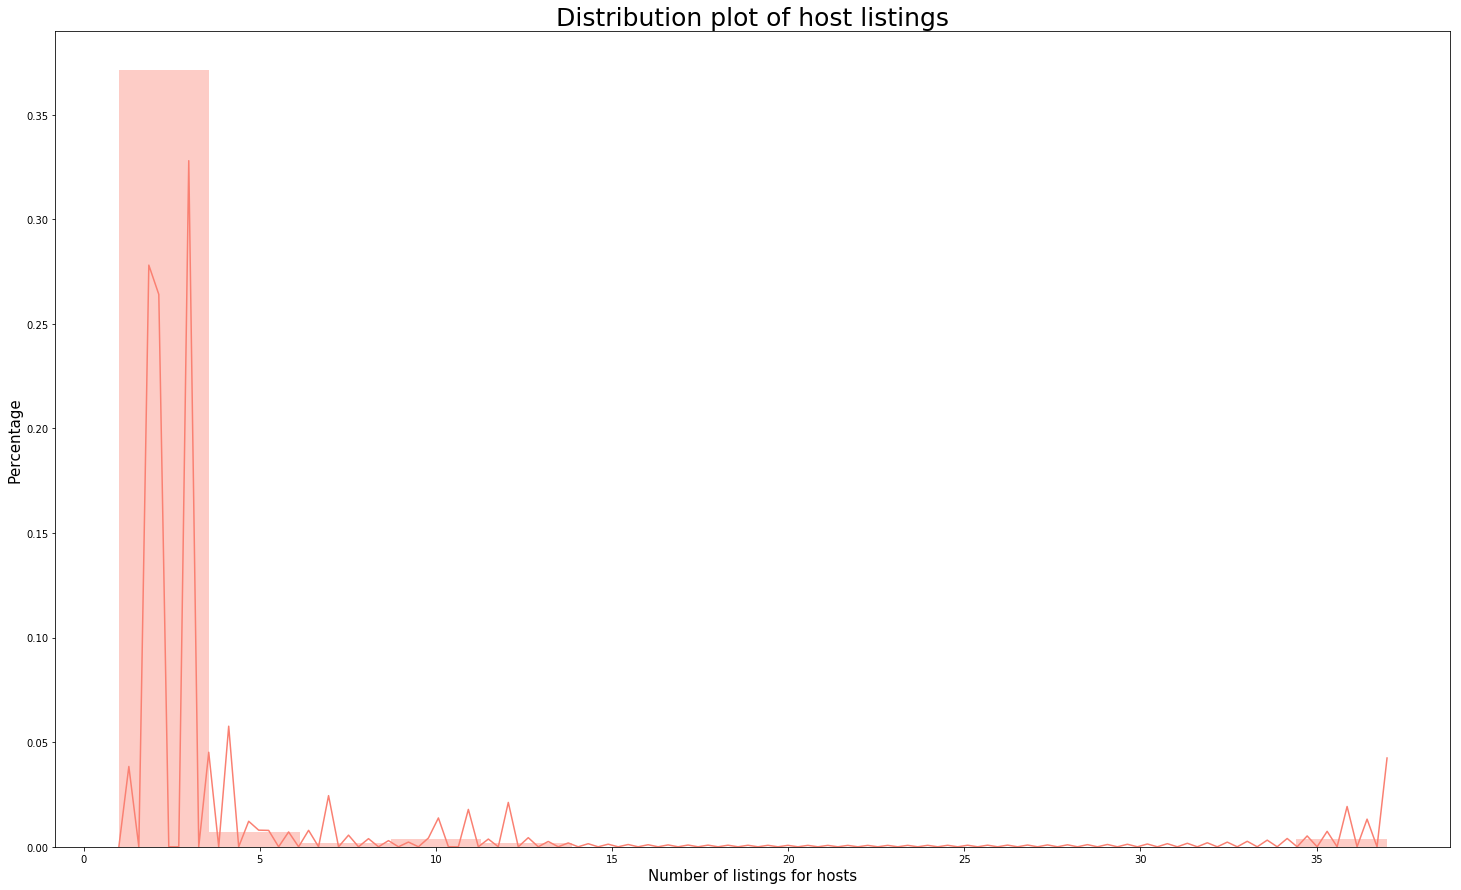

In [29]:
# Check number of hosts in this group
print(f'Number of unique hosts in this group is {four_years_host_listings.host_id.nunique()}')

# Check number of listings in this group
print(f'Number of unique listings in this group is {four_years_host_listings.id.nunique()}')

# Check mean listings/host
print(f'Average (Arithmetic Mean) number of listings per host is {four_years_host_listings.id.nunique()/four_years_host_listings.host_id.nunique():.2f}')

# Check trimmed mean listings/host
num_listings = four_years_host_listings.groupby(['host_id']).count()['id']
print(f'Average (Trimmed Mean, 0.05 Cut) number of listings per host is {trim_mean(num_listings, 0.05):.2f}')

# Check median listings/host
print(f'Average (Median) number of listings per host is {num_listings.median()}')

# Check mode listings/host
print(f'Average (Mode) number of listings per host is {float(num_listings.mode()[0])}')

# Simple distribution plot of listings/host
ax = sns.distplot(num_listings, color='salmon')
ax.set_title('Distribution plot of host listings', fontsize=25)
ax.set_ylabel('Percentage', fontsize=15)
ax.set_xlabel('Number of listings for hosts', fontsize=15)

Analysis:<br>

Using the averages and the distribution plot for analysis, it is clear that number of listings for hosts is a right skewed distribution with majority of hosts having 1 to 3 listings. The distribution quickly tails off with only a small noticeable proportion of hosts having 4 to 10 listings. Outliers can be observed from 15 listings and above with a significantly sized cluster at around 35 listings. These hosts are likely private firms that manage rental property and are using airbnb for all the properties that they manage.

#### Visualisation: Monthly Booking Rate by Superhost status for hosts with at least 4 years but less than 5 years hosting experience

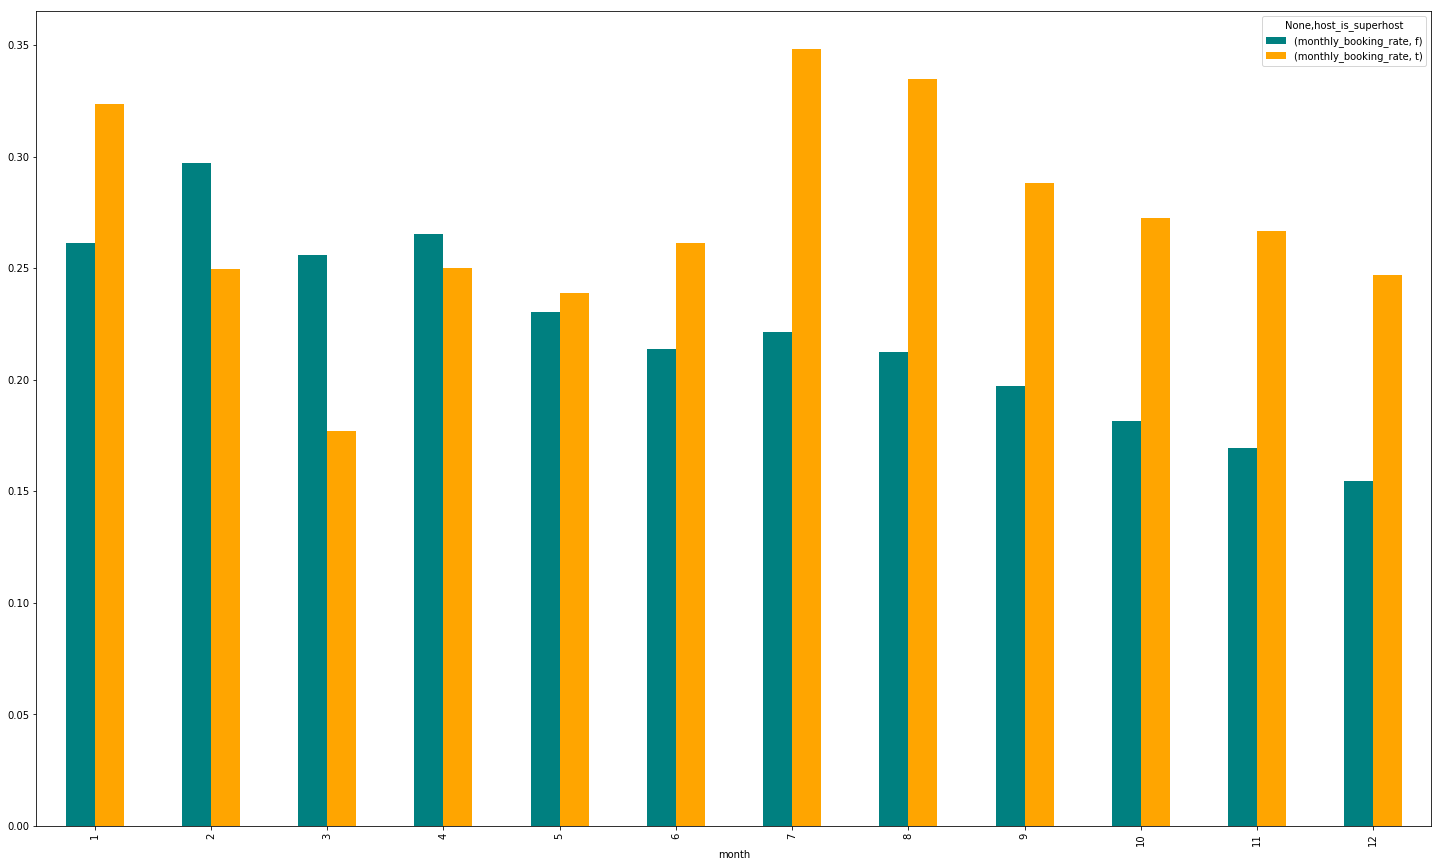

In [30]:
booking_rate_filter(monthly_booking_rate, four_years_host_listings, 'host_is_superhost', average_months=False, trim_proportion=0).unstack(0).plot(kind='bar', color=['teal', 'orange'])

Analysis: <br><br>
As expected, monthly booking rates for superhosts are significantly higher than those who are not with the exception of 3 months (February, March and April). This reinforces the intuition that superhost status plays a part in attaining higher booking rates for hosts of this group.

#### Visualisation: Heat Map of booking rate facted by verified host identify for hosts with at least 4 years but less than 5 years hosting experience

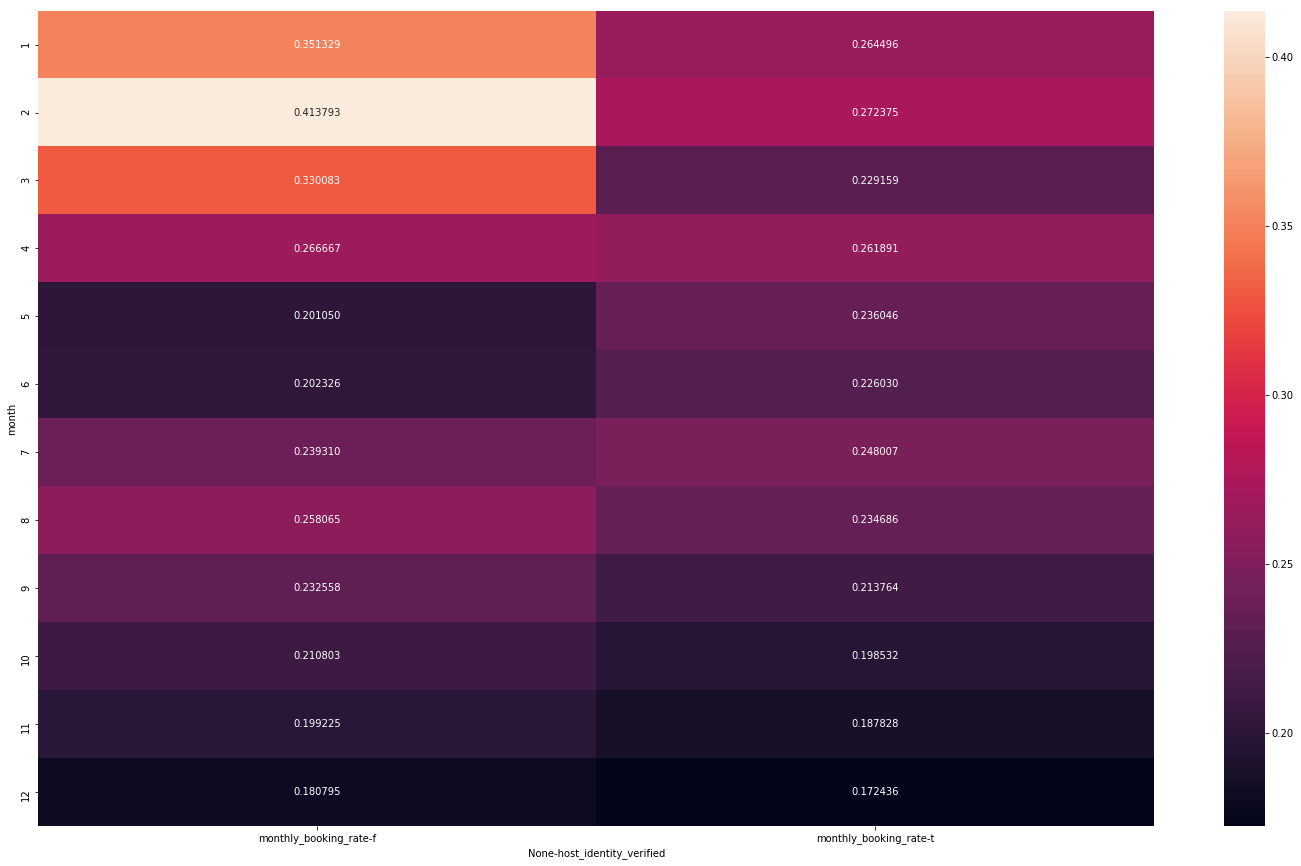

In [31]:
sns.heatmap(booking_rate_filter(monthly_booking_rate, four_years_host_listings, 'host_identity_verified', average_months=False, trim_proportion=0).unstack(0), annot=True, fmt="2f")

Analysis: <br>
    
There is a cluster of months (Januaray to March) where unverified hosts have higher booking rates than verified hosts. However, other months such as 5, 6, 7 (May, June, July) have shown higher booking rates for verified hosts than unverified hosts. Henceforth, no conclusive statements can be made on whether host verification has a signficant impact on booking rate and should be deemed as insignificant.

#### Visualisation: Donut charts of listing categorical variables for hosts with at least 4 years but less than 5 years hosting experience

Text(0.5, 0.98, 'Donut charts of 4-5 years hosts faceted by categorical variables')

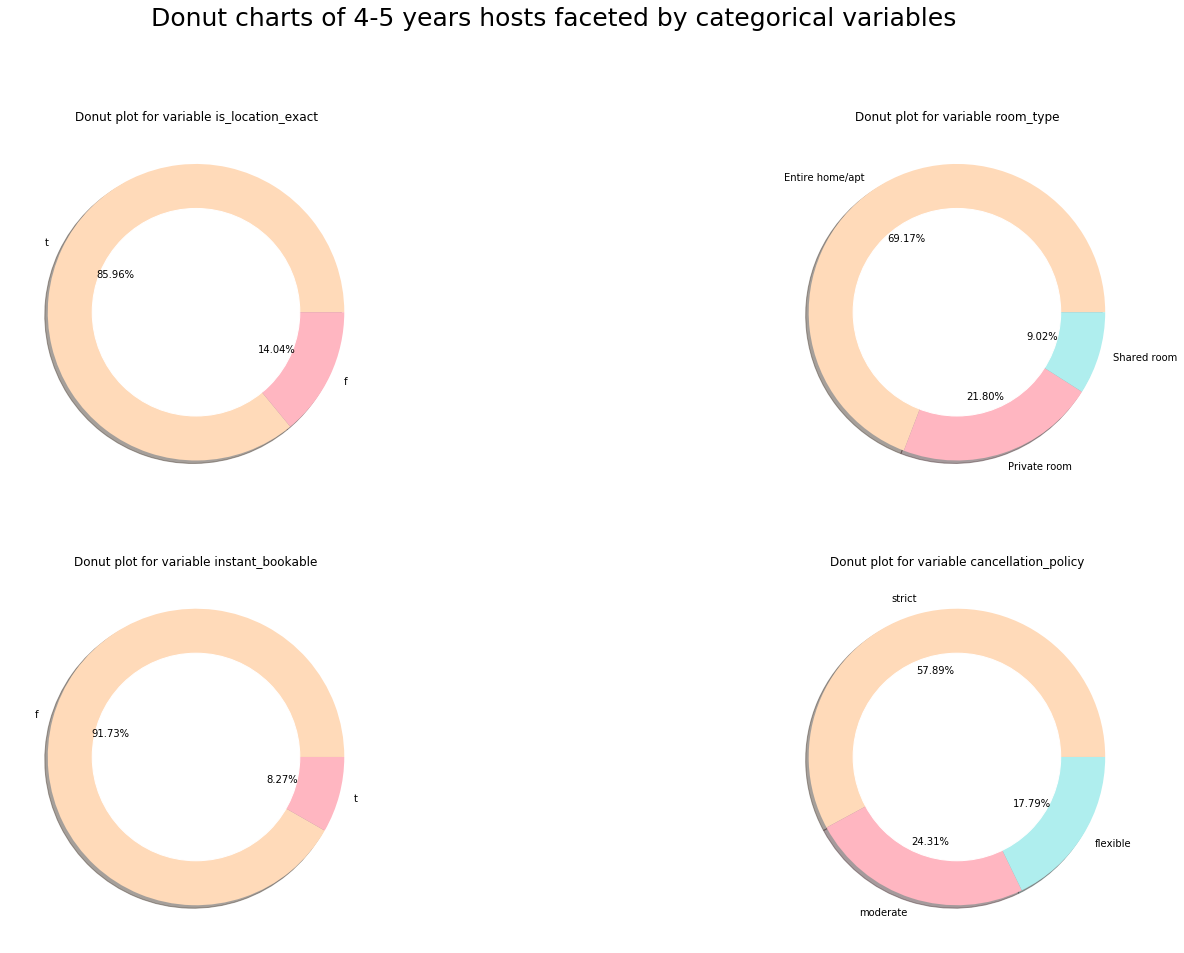

In [32]:
plot_vars = ['is_location_exact', 'room_type', 'instant_bookable', 'cancellation_policy']
fig, axes = plt.subplots(2, 2)
colours = ['peachpuff', 'lightpink', 'paleturquoise', 'lightgreen']

for index, var in enumerate(plot_vars):
    test = four_years_host_listings[var].value_counts()
    axes[int(index/2), int(index%2)].pie(test, labels=test.keys(), autopct='%1.2f%%', shadow=True, colors=colours)
    
    axes[int(index/2), int(index%2)].set_title(f'Donut plot for variable {var}')
    
    my_circle=plt.Circle( (0,0), 0.7, color='white')
    axes[int(index/2), int(index%2)].add_artist(my_circle)

fig.suptitle('Donut charts of 4-5 years hosts faceted by categorical variables', fontsize=25, va='center')

Analysis:<br>

Top-left donut plot: A large majority of 4-5 years hosts prefer to have their listings' location to be set as exact instead of set as an area. This indicates that they do not see any security repercussions and may be convinced that it will aid their potential customers in their accommodation selection.<br>

Top-right donut plot: Over 90% of listings either involves the rental of the entire apartment or a private room with almost 70% of the total coming from entire home/apartment rental. Only 9% of listings are of shared room accomodation which is not surprising as hostels provide fierce and direct competition against such listings.<br>

Bottom-left donut plot: Over 90% of listings are not instant bookable by nature which may be evidence that hosts do not see the benefits of making their listings instant bookable.

Bottom-right donut plot: Majority of the listings have strict cancellation policy (~58%) with only less than one-fifth (17.79%) having flexible cancellation policies. This will explored further on whether there is an impact on booking rates.

#### Visualisation: Monthly Booking Rate for hosts with at least 4 years but less than 5 years hosting experience by listing's cancellation policy

Text(0, 0.5, 'Month')

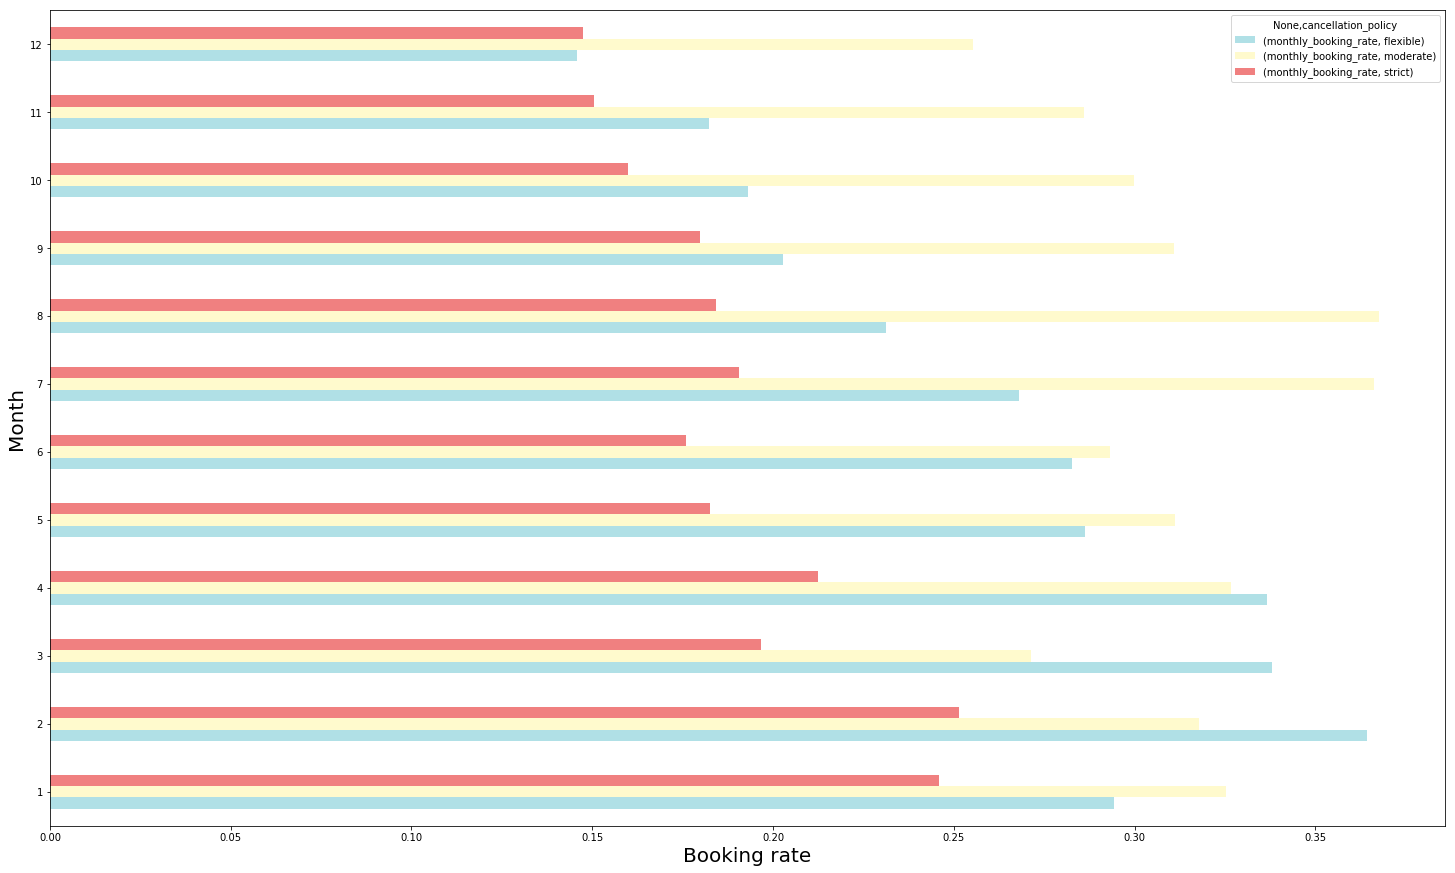

In [33]:
ax = booking_rate_filter(monthly_booking_rate, four_years_host_listings, 'cancellation_policy', average_months=False, trim_proportion=0).unstack(0).plot(kind='barh', color=['powderblue', 'lemonchiffon', 'lightcoral'])
ax.set_xlabel("Booking rate", fontsize=20)
ax.set_ylabel('Month', fontsize=20)

Analysis:<br>

To little surprise, strict cancellation policy listings perform the worst in terms of booking rates for almost all months. The only exception that it is not the worst performing group of listings is in the month of January (1) when flexible cancellation policy listings performed worse.<br>

Another interesting insight is that flexible cancellation policy listings did not performed the best for all the months in a year, topping the group in only for the months 2, 3, 4 (February, March and April).<br>

Moderate cancellation policy listings has the best booking rate performance as it led for 9 out of 12 months. Its relative performance to flexible cancellation policy listings can be reasoned as customers are less likely to cancel moderate cancellation listings bookings than flexible cancellation policy bookings due to the higher penalty imposed by moderate cancellation policy listings over flexible cancellation policy listings. <br>

Therefore, moderate cancellation policies appear to be the best in terms of maximising booking rate for listings in this group of hosts with 4-5 years hosting experience.

## Part III: Feature Engineering

In [34]:
def engineer_text_features(text_series):
    nlp = spacy.load('en')
    afinn_emo = Afinn(emoticons=True)
    return_dict = {'sentiment': None, 'pos': {}, 'ner': {}}
    
    # obtain sentiment scores using Afinn 
    return_dict['sentiment'] = text_series.apply(lambda text: afinn_emo.score(text) if not pd.isnull(text) else 0.0)
    
    # tokenise, remove stopwords and lemmatisation
    prepped_text_series = text_series.apply(lambda text: ' '.join([token.lemma_ for token in nlp(text) if token.is_stop != True and token.is_punct != True]) if not pd.isnull(text) else '')

    # pos tags counting
    def pos_counter(prepped_texts):
        prepped_texts_list = prepped_texts.apply(lambda prepped_text: [token.pos_ for token in nlp(prepped_text)]).tolist()
        adj, adv, intj, noun, pron, propn, verb = [], [], [], [], [], [], []
        for prepped_text in prepped_texts_list:
            pos_freq = Counter(prepped_text)
            adj.append(pos_freq['ADJ'])
            adv.append(pos_freq['ADV'])
            intj.append(pos_freq['INTJ'])
            noun.append(pos_freq['NOUN'])
            pron.append(pos_freq ['PRON'])
            propn.append(pos_freq['PROPN'])
            verb.append(pos_freq['VERB'])
        return adj, adv, intj, noun, pron, propn, verb
    
    pos = {}
    pos['adj'], pos['adv'], pos['intj'], pos['noun'], pos['pron'], pos['propn'], pos['verb'] = pos_counter(prepped_text_series)
    
    # named entity recognition counting
    def ner_counter(unprepped_texts):
        texts_ent_labels_list = unprepped_texts.apply(lambda text: [ent.label_ for ent in nlp(text).ents]  if not pd.isnull(text) else []).tolist()
        person, norp, fac, gpe, loc, product, money, event, work_of_art = [], [], [], [], [], [], [], [], []
        for text_ent_labels in texts_ent_labels_list:
            ner_freq = Counter(text_ent_labels)
            person.append(ner_freq['PERSON'])
            norp.append(ner_freq['NORP'])
            fac.append(ner_freq['FAC'])
            gpe.append(ner_freq['GPE'])
            loc.append(ner_freq['LOC'])
            product.append(ner_freq['PRODUCT'])
            money.append(ner_freq['MONEY'])
            event.append(ner_freq['EVENT'])
            work_of_art.append(ner_freq['WORK_OF_ART'])
        return person, norp, fac, gpe, loc, product, money, event, work_of_art
    
    ner = {}
    ner['person'], ner['norp'], ner['fac'], ner['gpe'], ner['loc'], ner['product'], ner['money'], ner['event'], ner['work_of_art'] = ner_counter(text_series)
    
    return_dict['pos'] = pos
    return_dict['ner'] = ner
    
    return return_dict

### Feature engineering for part-of-speech tag counts, named entity recognition label counts and sentiment scores for textual features

In [35]:
text_vars = ['name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'host_about']
for text_var in text_vars:
    return_dict = engineer_text_features(listings[text_var])
    listings[f'{text_var}_sentiment'] = return_dict['sentiment']
    for pos_tag, pos_tag_count in return_dict['pos'].items():
        listings[f'{text_var}_{pos_tag}'] = pos_tag_count
    for ner_tag, ner_tag_count in return_dict['ner'].items():
        listings[f'{text_var}_{ner_tag}'] = ner_tag_count

In [36]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,host_about_verb,host_about_person,host_about_norp,host_about_fac,host_about_gpe,host_about_loc,host_about_product,host_about_money,host_about_event,host_about_work_of_art
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,7,0,0,0,1,0,0,0,0,0
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,3,0,0,0,0,0,0,0,0,0
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,8,0,0,0,3,1,0,0,0,0
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,0,0,0,0,0,0,0,0,0,0
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,7,2,0,0,2,1,0,0,0,0


### Create new variable: Quartile that monthly booking rates of listings belong to in respect to all listings' monthly booking rates

In [7]:
def booking_rate_quartile(booking_rate_df, listings_df, by='airbnb_age'):
    years = booking_rate_df['year'].unique()
    return_df = booking_rate_df.set_index('listing_id').join(listings_df.set_index('id'), how='left').set_index(['month', 'year'], append=True)
    return_df['booking_rate_quartile'] = 0
    loop_df = return_df.copy(deep=True)
    unique_column_values = return_df[by].unique()
    for unique_value in unique_column_values:
        for month in range(1,13):
            for year in years:
                unique_value_df = loop_df[loop_df[by] == unique_value]
                unique_value_df = unique_value_df.loc[pd.IndexSlice[:, month, year], :]
                booking_rates_series = unique_value_df['booking_rate']
                q1_value, q2_value, q3_value = booking_rates_series.quantile(0.25), booking_rates_series.quantile(0.5), booking_rates_series.quantile(0.75)
                unique_value_df['booking_rate_quartile'] = unique_value_df['booking_rate'].apply(lambda booking_rate: 
                                                                                                 1 if booking_rate <= q1_value else 
                                                                                                 (2 if booking_rate <= q2_value else 
                                                                                                  (3 if booking_rate <= q3_value else 4)))
                return_df.update(unique_value_df['booking_rate_quartile'], join='left')
    return_df['booking_rate_quartile'] = return_df['booking_rate_quartile'].apply(lambda quartile: int(quartile))
    return return_df.reset_index().rename({'level_0': 'listing_id'}, axis=1)

#### Save updated dataframe with engineered features to save on computational time for further computations

In [ ]:
try:
    listings_booking_rate_quartile = booking_rate_quartile(monthly_booking_rate, listings)
except NameError:
    monthly_booking_rate = pd.read_csv('monthly_booking_rate.csv')
    listings = pd.read_csv('engineered_listings_before_booking_rate_quartile.csv')
    listings_booking_rate_quartile = booking_rate_quartile(monthly_booking_rate, listings)

In [39]:
listings_booking_rate_quartile.to_csv('listings_booking_rate_quartile.csv', index=False)

## Part IV: Further analysis on 4-5 years hosts' listings with engineered features

In [9]:
# replace existing four_years_host_listings with new df with new features
try:
    four_years_host_listings = listings_booking_rate_quartile[listings_booking_rate_quartile['airbnb_age'] == '4 years <= & < 5 years']
except NameError:
    listings_booking_rate_quartile = pd.read_csv('listings_booking_rate_quartile.csv')
    four_years_host_listings = listings_booking_rate_quartile[listings_booking_rate_quartile['airbnb_age'] == '4 years <= & < 5 years']

### Visualising engineered features distribution against aggregated booking rates

In [41]:
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:grey', 'tab:olive', 'tab:cyan', 'gold', 'mediumspringgreen']
text_vars = ['name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'host_about']

def plotter_helper(listings_df, text_vars_list, engineered_feature_name, colour_list, plot_kind='bar'):
    rows = int(len(text_vars_list)/3)
    if len(text_vars_list)%3 > 0:
        rows += 1
    columns = 3
    fig, axes = plt.subplots(rows, columns)
    for index, text_var in enumerate(text_vars_list):
        text_var_df = booking_rate_filter(None, listings_df, f'{text_var}_{engineered_feature_name}', average_months=True, trim_proportion=0, joined_df_only=False).reset_index()
        ax = text_var_df.plot(f'{text_var}_{engineered_feature_name}', 'average_monthly_booking_rate', kind=plot_kind, ax=axes[int(index/columns), int(index%columns)], color=colour_list[index%len(colour_list)])
        ax.set_title(f'{text_var}_{engineered_feature_name}')
        ax.set_xlabel("")

#### Visualisation: Joint plots (Monthly Booking Rate and Sentiment Score) for hosts with at least 4 years but less than 5 years hosting experience

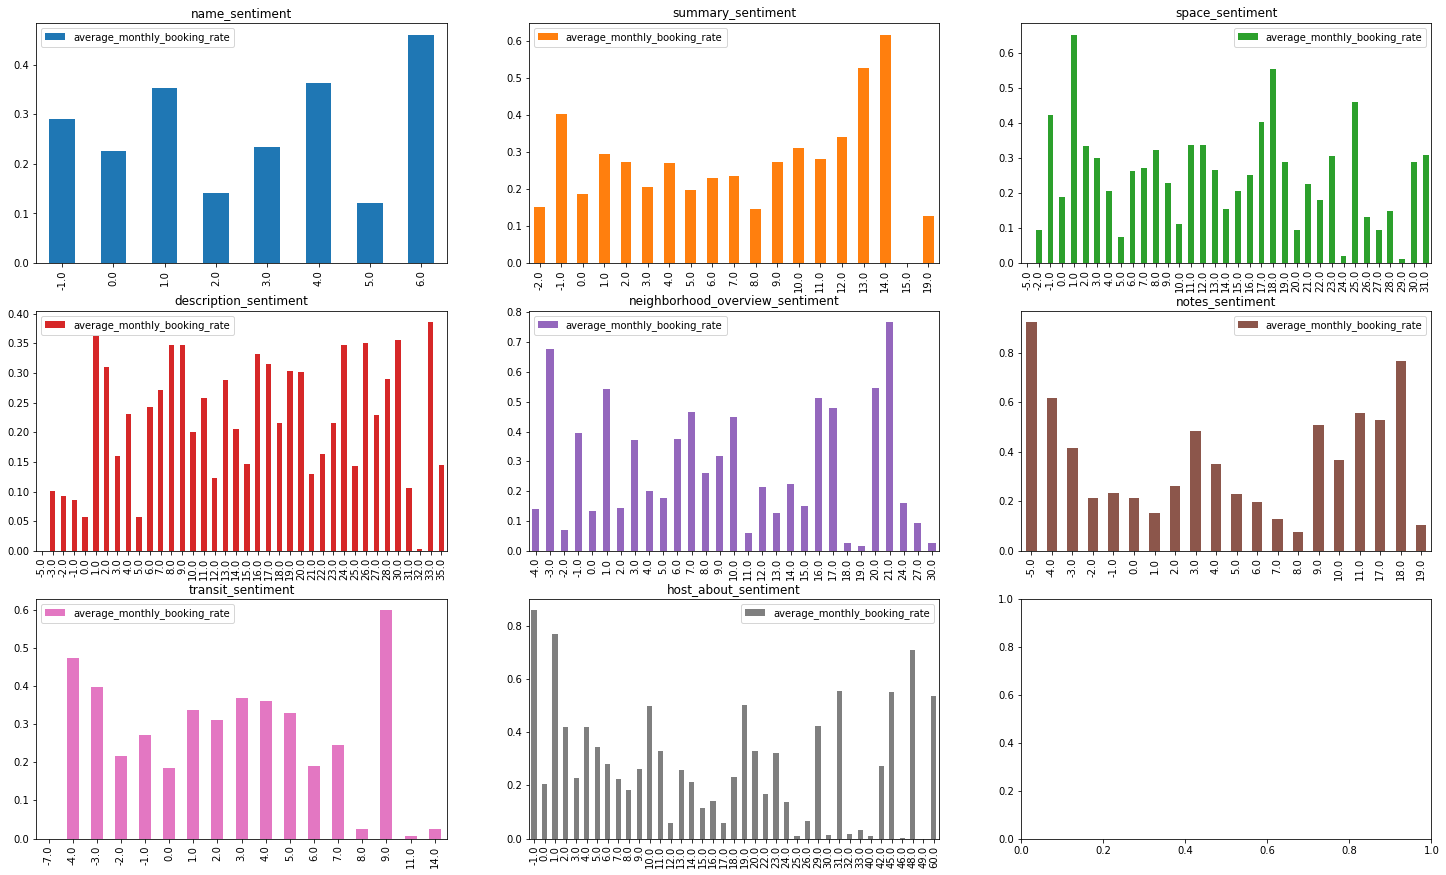

In [42]:
plotter_helper(four_years_host_listings, text_vars, 'sentiment', colour_list=colours, plot_kind='bar')

Analysis:<br>

The sentiment score joint plots for all selected text features are observed to share a highly similiar pattern with maximum average monthly booking rate being situated either at negative sentiment scores, at relatively high sentiment scores. The only exception to this is for the space textual feature where average monthly booking rate peaks at sentiment score = 1. It is evident that the magnitude of sentiment score of for textual featuress have an impact on the booking rate for a listing. <br>

However, the charts above are not independent of one another as a host who tend to write highly positive text for a listing's summary is highly likely to write a highly positive text for its description as well.

#### Visualisation: Joint plots (Monthly Booking Rate and Number of Adjectives) for hosts with at least 4 years but less than 5 years hosting experience

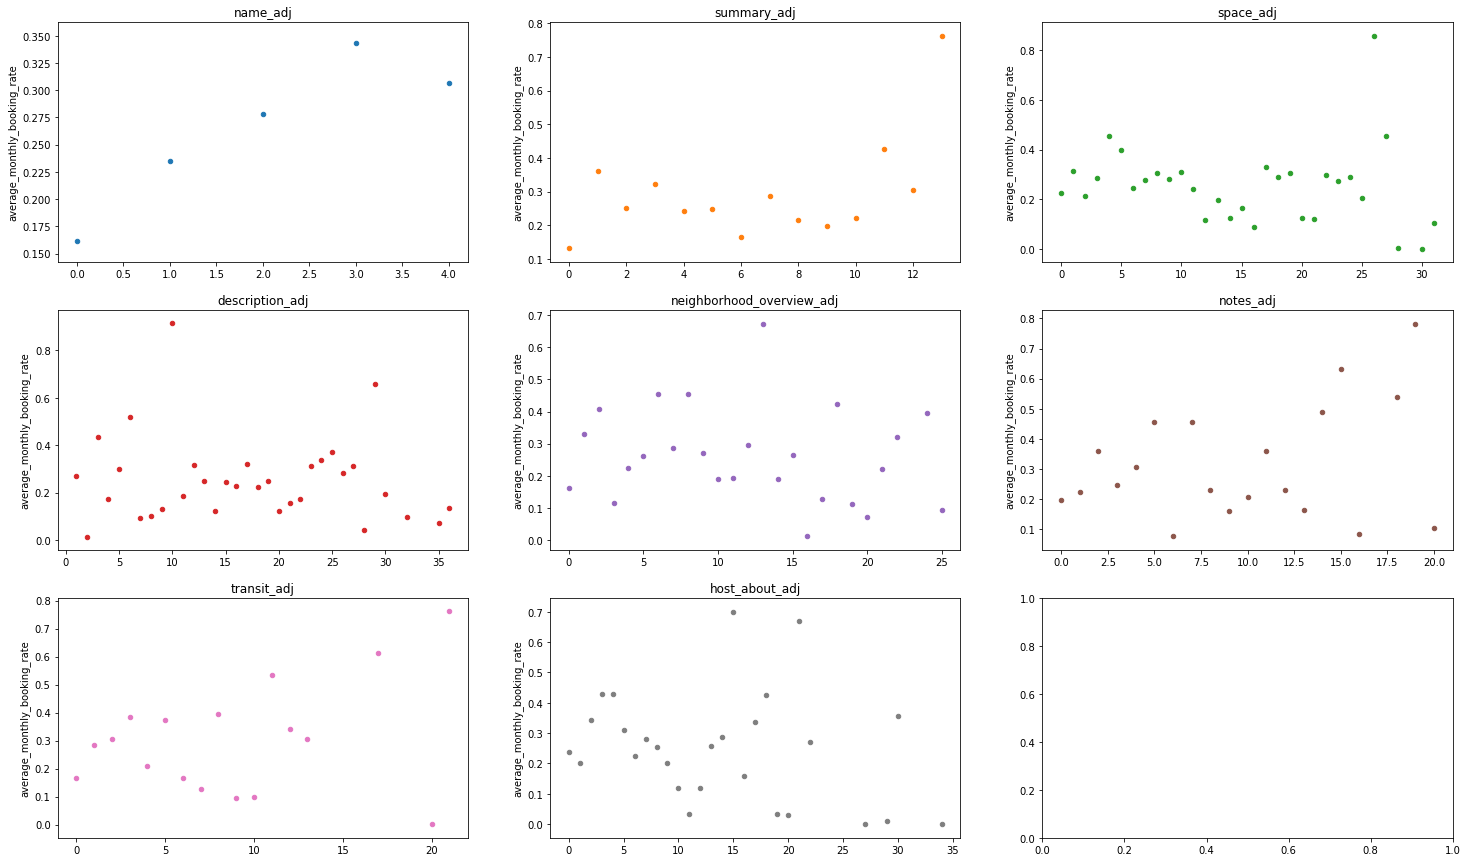

In [43]:
plotter_helper(four_years_host_listings, text_vars, 'adj', colour_list=colours, plot_kind='scatter')

Analysis:<br>

By analysing all the charts simultaneously, it is evident that majority of listings fall within the same cluster of average monthly booking rates, possibily an indication that the number of adjectives in textual features do not have any impact on the booking rates. <br>

However, there are outliers observed in this chart with starkingly contrasting average monthly booking rates. This can be observed from the notes_adj chart (row 2 column 3) as the highest average monthly booking rate (~0.8) listing have the second highest number of adjectives but the listing with the highest number of adjectives can be seen to have an extremely low average booking rate (~0.1). Therefore, the number of adjectives is likely to have no true on booking rates.

#### Visualisation: Joint plots (Monthly Booking Rate and Number of Pronouns) for hosts with at least 4 years but less than 5 years hosting experience

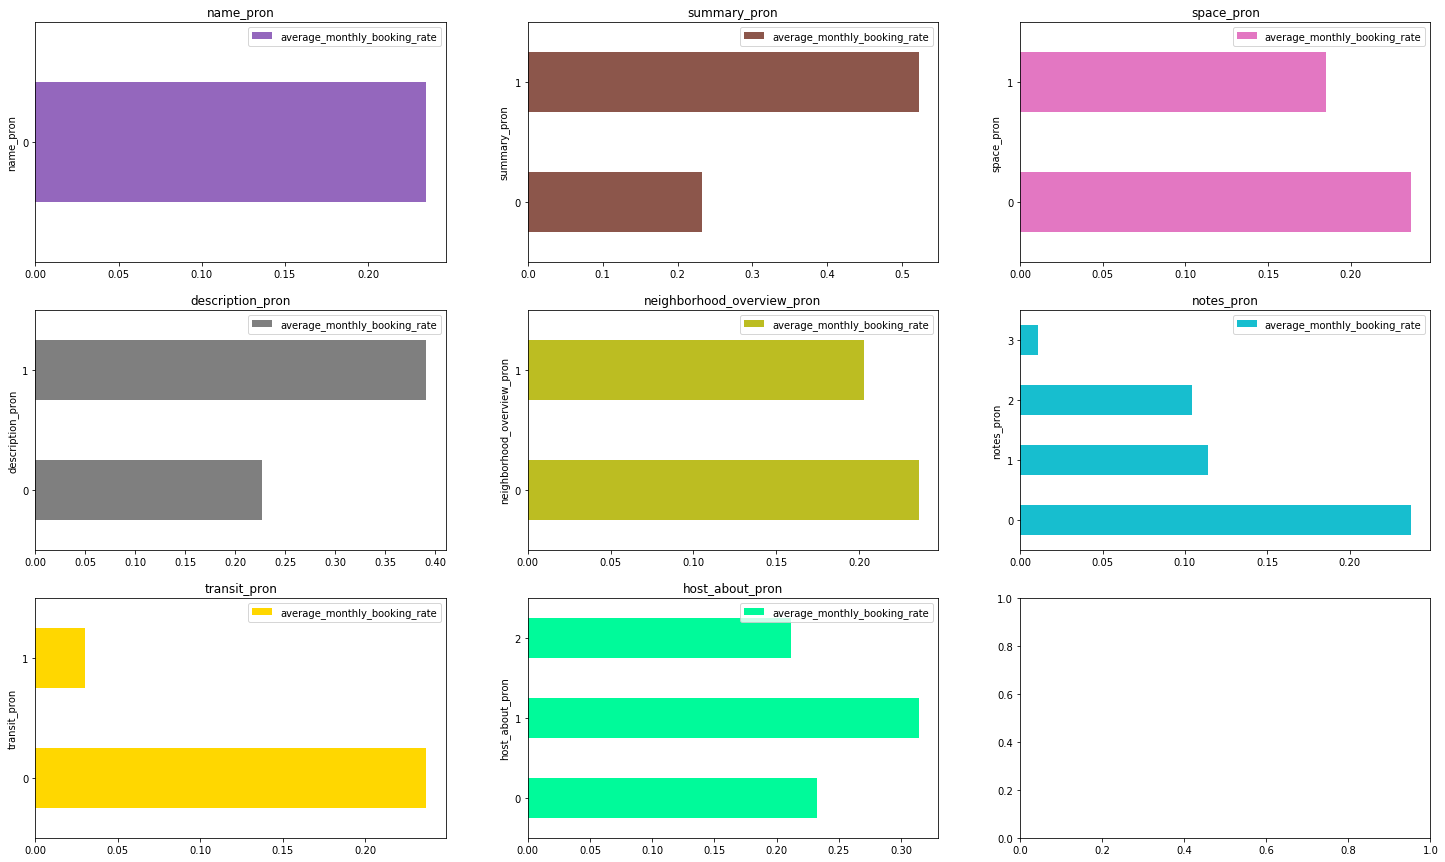

In [44]:
plotter_helper(four_years_host_listings, text_vars, 'pron', colour_list=colours[4:], plot_kind='barh')

Analysis:<br>

It can be seen that all selected textual features have very few pronouns in their respective text values, with the max being 3 pronouns as seen in the notes_pron visualisation. Hence, it is clear that hosts of this group tend not to heavily document their listing from a first-person perspective. In addition, no common signal can be observed from the charts as the peak nor lowest average monthly booking rate does not appear to be similiarly centralised at a location in the various plots.  

#### Visualisation: Joint plots (Monthly Booking Rate and Number of [FACs](https://spacy.io/api/annotation#section-named-entities)) for hosts with at least 4 years but less than 5 years hosting experience

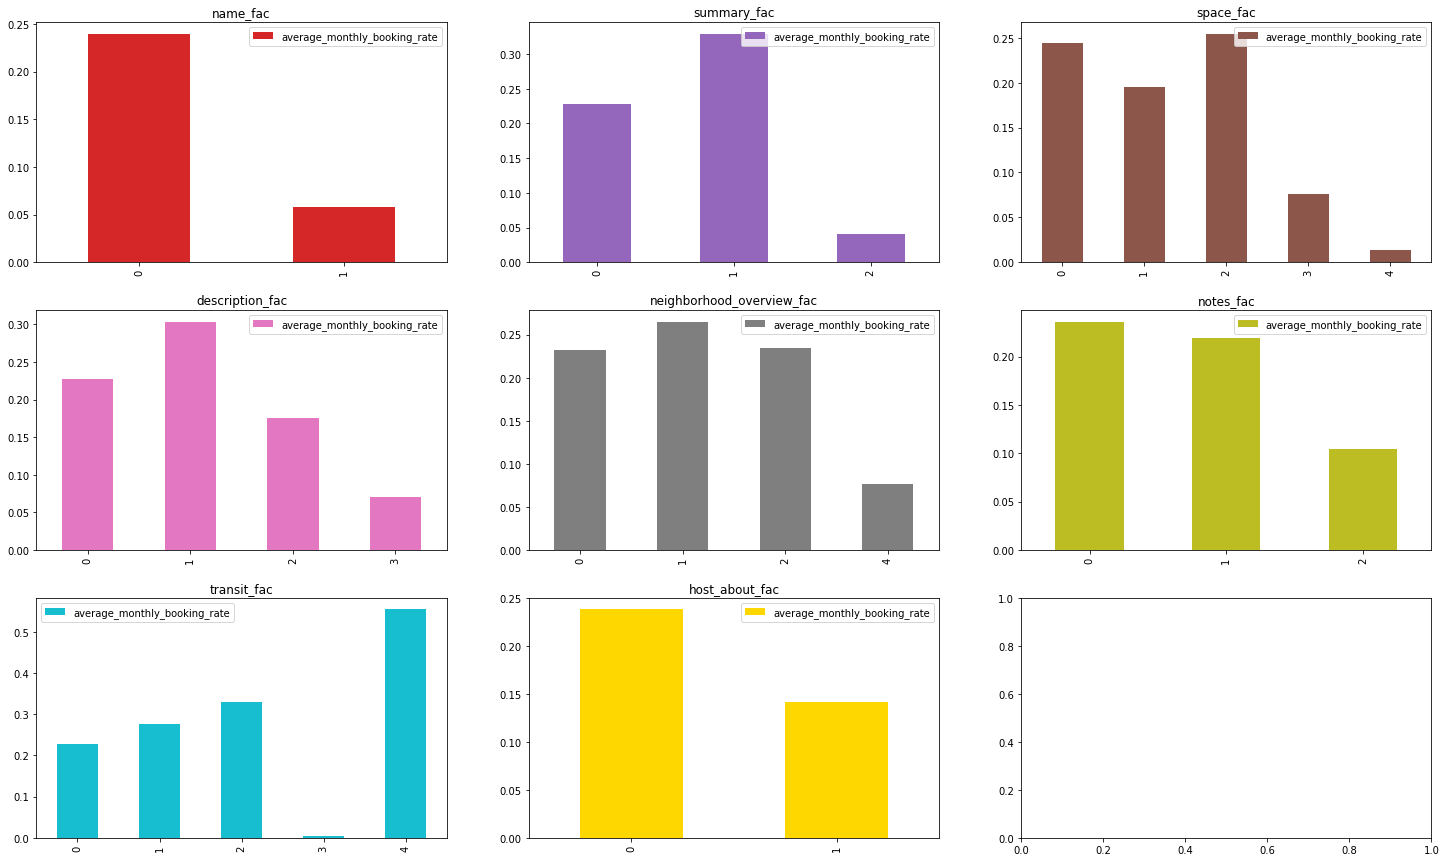

In [45]:
plotter_helper(four_years_host_listings, text_vars, 'fac', colour_list=colours[3:-1], plot_kind='bar')

Analysis:<br>

FAC as a named entity tag represents identified Buildings, airports, highways, bridges, etc and from glancing at the visualisations, no correlation can be observed between the number of named entities of this nature and the average monthly booking rates as there is no observable common trend between the plots. 

#### Visualisation: Joint plots (Monthly Booking Rate and Number of [GPEs](https://spacy.io/api/annotation#section-named-entities)) for hosts with at least 4 years but less than 5 years hosting experience

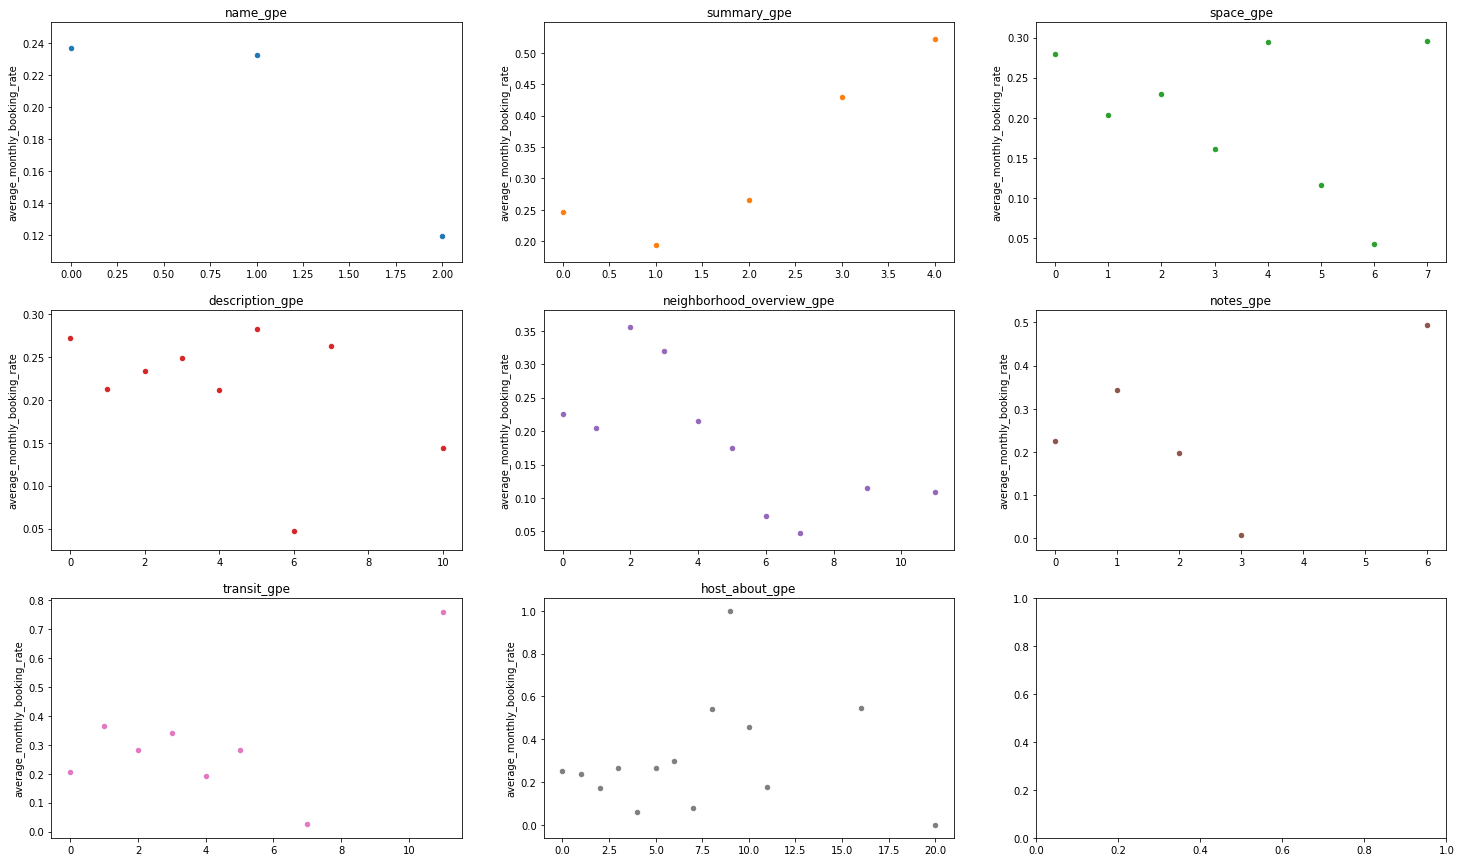

In [46]:
plotter_helper(four_years_host_listings, text_vars, 'gpe', colour_list=colours, plot_kind='scatter')

Analysis:<br>

GPE is a named entity tag that represents countries, cities and states.<br>

Similiarly to previous set of joint plots (Monthly Booking Rate and Number of FACs), there is no observable correlation as evident from comparing summary_gpe plot and neighborhood_overview_gpe plot as their fitted trend line have contrasting gradients.

### Identifying poor performing listings and well performing listings and visualising features distributions

#### Prep dataframe

In [47]:
four_years_host_listings_filtered = four_years_host_listings[['listing_id', 'year', 'month', 'booking_rate_quartile']]

#### Identifying poor performing listings
Deemed as listings with all monthly booking rate quartile being below or equal median (q1 or q2)<br>
There are 13 months in the dataframe, 2016 January to 2017 January inclusive

In [48]:
lower_half_df = four_years_host_listings_filtered[four_years_host_listings_filtered['booking_rate_quartile'] <= 2]
lower_half_months_count = lower_half_df.groupby(['listing_id']).size()
poor_performing_listings = lower_half_months_count[lower_half_months_count == 13].index
poor_performing_four_years_listings = four_years_host_listings[four_years_host_listings['listing_id'].isin(poor_performing_listings)]

In [49]:
poor_performing_four_years_listings.head()

,listing_id,month,year,booking_rate,listing_url,scrape_id,last_scraped,name,summary,space,...,host_about_person,host_about_norp,host_about_fac,host_about_gpe,host_about_loc,host_about_product,host_about_money,host_about_event,host_about_work_of_art,booking_rate_quartile
754,80188,1,2016,0.0,https://www.airbnb.com/rooms/80188,20160104002432,2016-01-04,Seattle North Beach B R Guest Suite,"Great location; far enough to be peaceful, clo...",455 sq. Ft. Lower Garden Level Guest Suites pl...,...,7,4,0,4,0,0,0,0,0,1
755,80188,2,2016,0.0,https://www.airbnb.com/rooms/80188,20160104002432,2016-01-04,Seattle North Beach B R Guest Suite,"Great location; far enough to be peaceful, clo...",455 sq. Ft. Lower Garden Level Guest Suites pl...,...,7,4,0,4,0,0,0,0,0,1
756,80188,3,2016,0.0,https://www.airbnb.com/rooms/80188,20160104002432,2016-01-04,Seattle North Beach B R Guest Suite,"Great location; far enough to be peaceful, clo...",455 sq. Ft. Lower Garden Level Guest Suites pl...,...,7,4,0,4,0,0,0,0,0,1
757,80188,4,2016,0.0,https://www.airbnb.com/rooms/80188,20160104002432,2016-01-04,Seattle North Beach B R Guest Suite,"Great location; far enough to be peaceful, clo...",455 sq. Ft. Lower Garden Level Guest Suites pl...,...,7,4,0,4,0,0,0,0,0,1
758,80188,5,2016,0.0,https://www.airbnb.com/rooms/80188,20160104002432,2016-01-04,Seattle North Beach B R Guest Suite,"Great location; far enough to be peaceful, clo...",455 sq. Ft. Lower Garden Level Guest Suites pl...,...,7,4,0,4,0,0,0,0,0,1


#### Identifying well performing listings

In [50]:
upper_half_df = four_years_host_listings_filtered[four_years_host_listings_filtered['booking_rate_quartile'] > 2]
upper_half_months_count = upper_half_df.groupby(['listing_id']).size()
well_performing_listings = upper_half_months_count[upper_half_months_count == 13].index
well_performing_four_years_listings = four_years_host_listings[four_years_host_listings['listing_id'].isin(well_performing_listings)]

In [51]:
well_performing_four_years_listings.head()

,listing_id,month,year,booking_rate,listing_url,scrape_id,last_scraped,name,summary,space,...,host_about_person,host_about_norp,host_about_fac,host_about_gpe,host_about_loc,host_about_product,host_about_money,host_about_event,host_about_work_of_art,booking_rate_quartile
858,107046,1,2016,1.0,https://www.airbnb.com/rooms/107046,20160104002432,2016-01-04,"Beautiful, Artistic Home, near UW",Why not stay in a quintessential Seattle Bunga...,This charming Seattle Bungalow was built in th...,...,1,0,0,1,0,0,0,0,0,4
859,107046,2,2016,1.0,https://www.airbnb.com/rooms/107046,20160104002432,2016-01-04,"Beautiful, Artistic Home, near UW",Why not stay in a quintessential Seattle Bunga...,This charming Seattle Bungalow was built in th...,...,1,0,0,1,0,0,0,0,0,4
860,107046,3,2016,1.0,https://www.airbnb.com/rooms/107046,20160104002432,2016-01-04,"Beautiful, Artistic Home, near UW",Why not stay in a quintessential Seattle Bunga...,This charming Seattle Bungalow was built in th...,...,1,0,0,1,0,0,0,0,0,4
861,107046,4,2016,1.0,https://www.airbnb.com/rooms/107046,20160104002432,2016-01-04,"Beautiful, Artistic Home, near UW",Why not stay in a quintessential Seattle Bunga...,This charming Seattle Bungalow was built in th...,...,1,0,0,1,0,0,0,0,0,4
862,107046,5,2016,1.0,https://www.airbnb.com/rooms/107046,20160104002432,2016-01-04,"Beautiful, Artistic Home, near UW",Why not stay in a quintessential Seattle Bunga...,This charming Seattle Bungalow was built in th...,...,1,0,0,1,0,0,0,0,0,4


#### Visualising features of poor performing listings and well performing listings

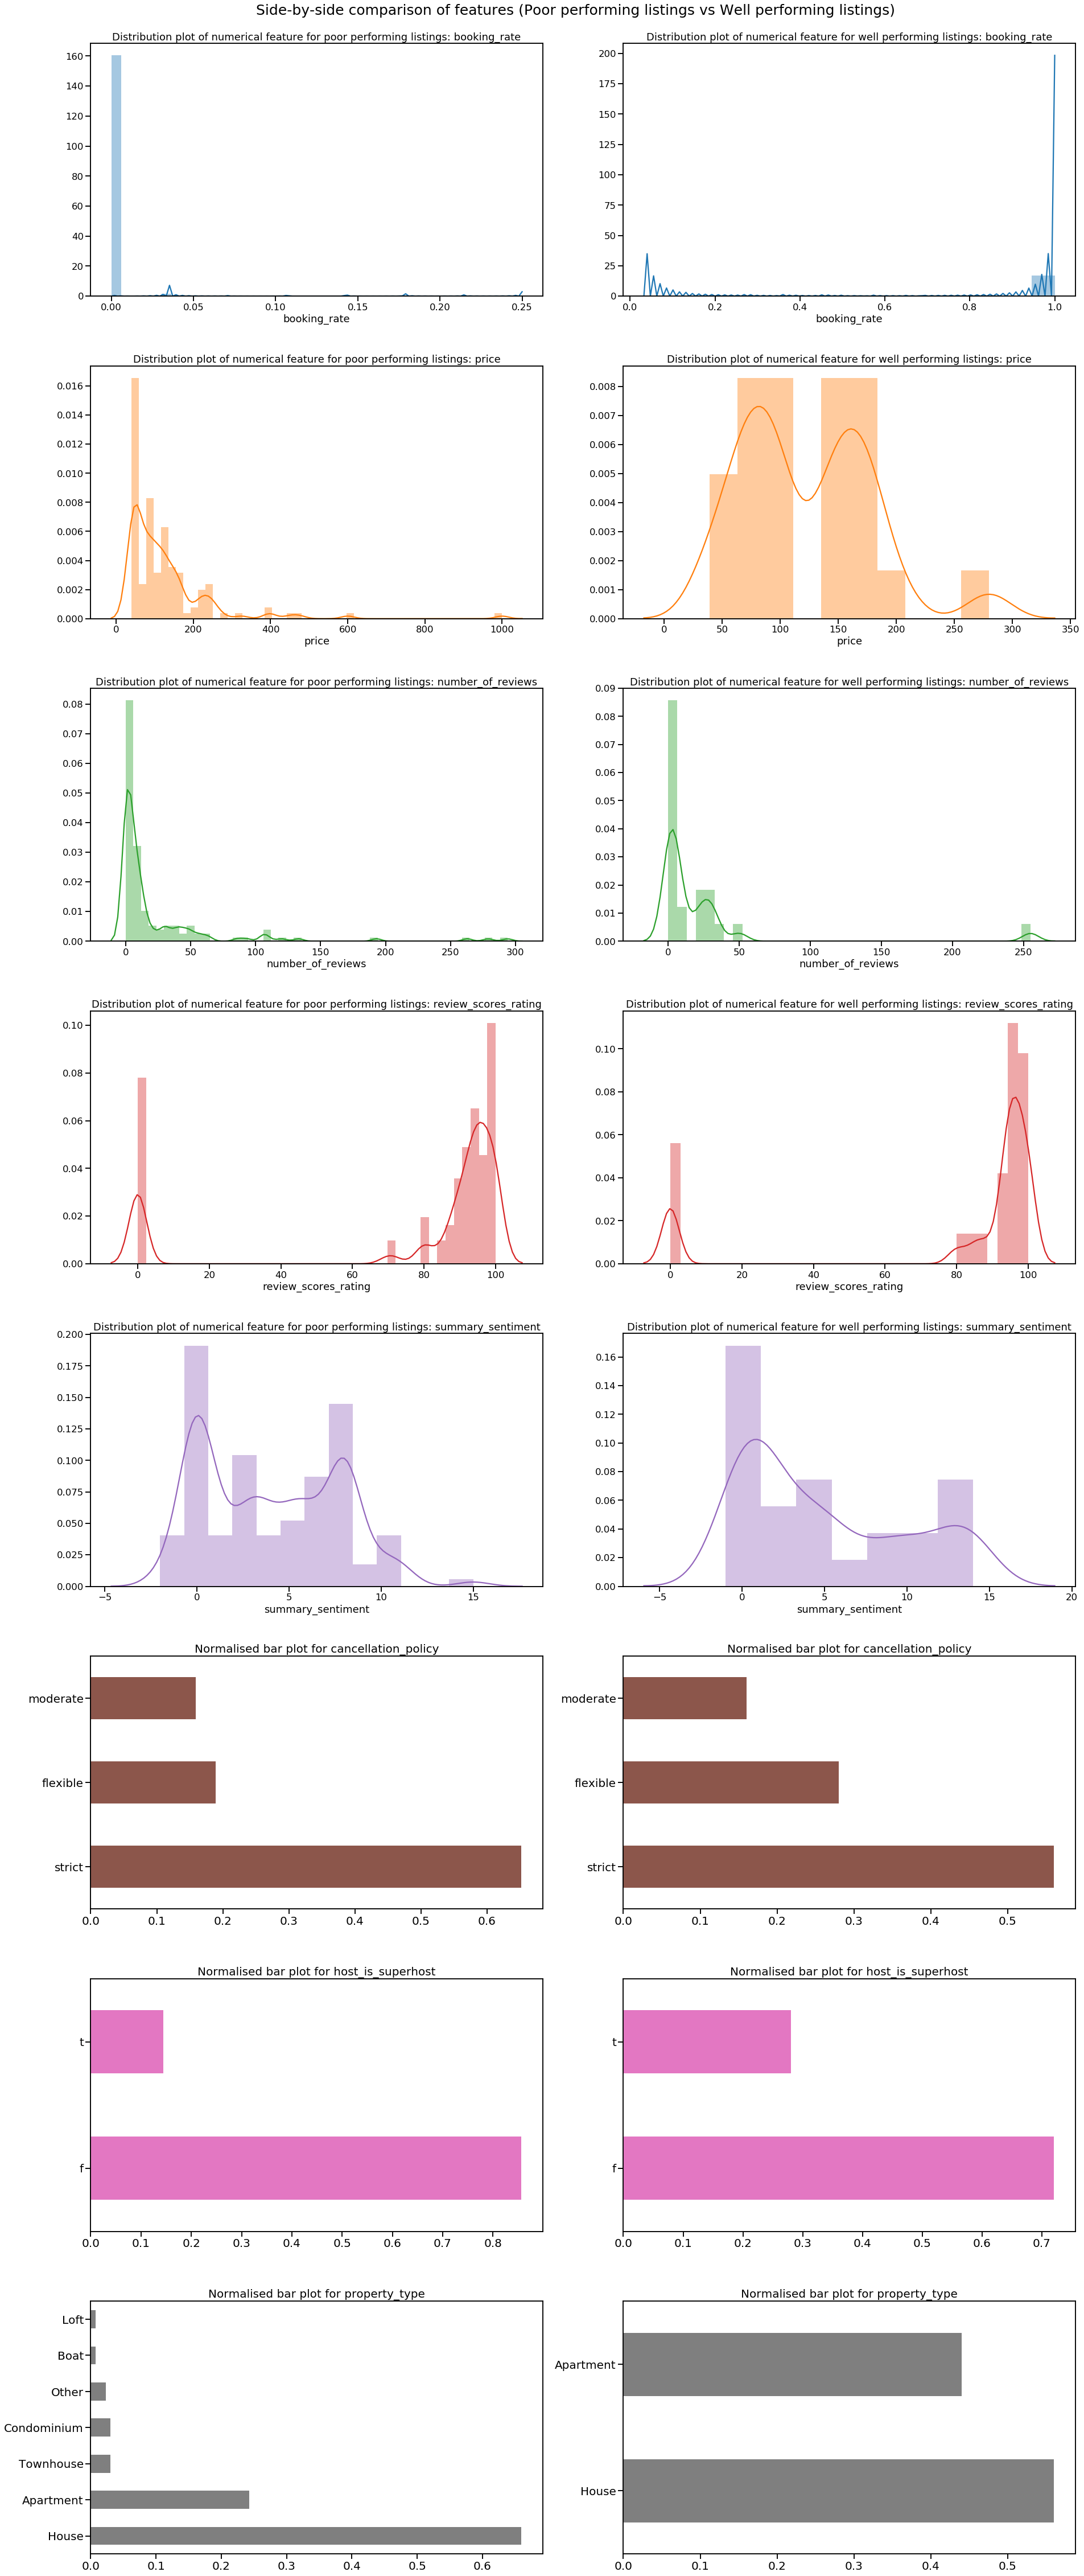

In [53]:
sns.set_context("talk")
list_of_features = {'numeric': ['booking_rate', 'price', 'number_of_reviews', 'review_scores_rating', 'summary_sentiment'], 
                    'categorical': ['cancellation_policy', 'host_is_superhost', 'property_type']}
num_rows = len(list_of_features['numeric']) + len(list_of_features['categorical'])
num_cols = 2
fig_height = 8.0*num_rows
fig, axes = plt.subplots(num_rows, num_cols, figsize=(25.0, fig_height))
fig.tight_layout(pad=0.5, h_pad=5.0, w_pad=5.0)
fig.subplots_adjust(top=0.965)
fig.suptitle('Side-by-side comparison of features (Poor performing listings vs Well performing listings)', fontsize=25)
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:grey', 'tab:olive', 'tab:cyan', 'gold', 'mediumspringgreen']
index = 0

for feature_type, feature_list in list_of_features.items():
    if feature_type == 'numeric':
        for feature in feature_list:
            sns.distplot(poor_performing_four_years_listings[poor_performing_four_years_listings[feature].notnull()][feature], 
                         ax=axes[index, 0], color=colours[index], axlabel=feature, kde=True).set_title(f'Distribution plot of numerical feature for poor performing listings: {feature}', fontsize=18)
            sns.distplot(well_performing_four_years_listings[well_performing_four_years_listings[feature].notnull()][feature], 
                         ax=axes[index, 1], color=colours[index], axlabel=feature, kde=True).set_title(f'Distribution plot of numerical feature for well performing listings: {feature}', fontsize=18)
            index += 1
            
    else:
        for feature in feature_list:
            ax1 = poor_performing_four_years_listings[feature].value_counts(normalize=True).plot(kind='barh', ax=axes[index, 0], color=colours[index], fontsize=20)
            ax1.set_title(f'Normalised bar plot for {feature}', fontsize=20)
            ax1.set_xlabel("")
            ax2 = well_performing_four_years_listings[feature].value_counts(normalize=True).plot(kind='barh', ax=axes[index, 1], color=colours[index], fontsize=20)
            ax2.set_title(f'Normalised bar plot for {feature}', fontsize=20)
            ax2.set_xlabel("")
            index += 1

Analysis:<br>

From the pair plots, there are a few interesting observations.<br>

(Orange Plot)
Firstly, the spread of poor performing listings' prices is much larger than the spread of well performing listings prices with a range of \\$1000 compared to \\$350. This is empirical evidence that more affordable listings are booked way more often than those that are pricey and that there is a price threshold of $350 per night to Airbnb users for this group of listings.<br>

(Red Plot)
Secondly, the range of review score ratings for the two subgroups is significantly different as well as the poorer performing listing group has a range of approximately 30 whereas the better performing list group has a range of approxiamtely 20. The better performing listing group has a greater proportion of ratings clustered at 100 than the poorer performing listing group.<br>

(Brown Plot)
Thirdly, the cancellation policy plots show little noticable difference upon first glance. However, it can be noted that the proportion of strict cancellation policy for better preforming listings is lower than its worse performing counterparts with an estimated proportion of 0.55 and 0.65 respectively. The difference in proportion is accounted for in the difference in proportion between flexible cancellation policies as the better performing listings subgroup has estimated proportion of 0.28 compared with 0.19 of the poor performing listings subgroup.

(Grey Plot)
Lastly, the property type plots show that the well performing listings group only consist of 2 unique types of property with apartment and house being its unique property types. The poor performing listings group have a larger range of unique property types with a small minority being properties such as boats, lofts, townhouses and condominiums. It is highly indicative that demand for apartment and house is higher than other forms of property types for listings belonging to this group of hosts (hosts with 4-5 years Airbnb experience)

## Part V: Classification: modeling listing month's booking rate quartile performance

### Prepare features, encode categorical features into numerical values and standardise numerical features

In [10]:
# group by months and average values first
all_data = listings_booking_rate_quartile.copy(deep=True)
aggregated_months = listings_booking_rate_quartile.groupby(['listing_id', 'month']).mean().drop('year', axis=1).reset_index()
all_data.update(aggregated_months)

# deal with different types of features
binary_features = [f'{feature_name}_exist' for feature_name in convert_binary_features_url] + [f'{feature_name}_1' for feature_name in convert_binary_features_tf]

categorical_features = ['month', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 'cancellation_policy']

text_vars_ = [f'{text_var}_' for text_var in ['name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'host_about']]
engineered_text_features = []
for column in listings_booking_rate_quartile.columns:
    for text_var_ in text_vars_:
        if text_var_ in column:
            engineered_text_features.append(column)

numerical_features = ['price', 'security_deposit', 'cleaning_fee', 'accommodates', 'bathrooms', 
                      'bedrooms', 'beds', 'extra_people', 'number_of_reviews', 'review_scores_rating',
                      'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                      'review_scores_communication', 'review_scores_location', 'review_scores_value',
                      'calculated_host_listings_count']

View and check all features' types first

In [56]:
all_data[binary_features].head()

,thumbnail_url_exist,medium_url_exist,picture_url_exist,xl_picture_url_exist,host_has_profile_pic_1,host_identity_verified_1,is_location_exact_1,instant_bookable_1,require_guest_profile_picture_1,require_guest_phone_verification_1
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0


In [57]:
all_data[binary_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49634 entries, 0 to 49633
Data columns (total 10 columns):
thumbnail_url_exist                   49634 non-null float64
medium_url_exist                      49634 non-null float64
picture_url_exist                     49634 non-null float64
xl_picture_url_exist                  49634 non-null float64
host_has_profile_pic_1                49634 non-null float64
host_identity_verified_1              49634 non-null float64
is_location_exact_1                   49634 non-null float64
instant_bookable_1                    49634 non-null float64
require_guest_profile_picture_1       49634 non-null float64
require_guest_phone_verification_1    49634 non-null float64
dtypes: float64(10)
memory usage: 3.8 MB


In [58]:
all_data[categorical_features].head()

,month,neighbourhood_cleansed,property_type,room_type,bed_type,cancellation_policy
0,1.0,Dunlap,House,Entire home/apt,Real Bed,strict
1,2.0,Dunlap,House,Entire home/apt,Real Bed,strict
2,3.0,Dunlap,House,Entire home/apt,Real Bed,strict
3,4.0,Dunlap,House,Entire home/apt,Real Bed,strict
4,5.0,Dunlap,House,Entire home/apt,Real Bed,strict


In [11]:
all_data[categorical_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49634 entries, 0 to 49633
Data columns (total 6 columns):
month                     49634 non-null float64
neighbourhood_cleansed    49634 non-null object
property_type             49634 non-null object
room_type                 49634 non-null object
bed_type                  49634 non-null object
cancellation_policy       49634 non-null object
dtypes: float64(1), object(5)
memory usage: 2.3+ MB


In [60]:
all_data[engineered_text_features].head()

,name_sentiment,name_adj,name_adv,name_intj,name_noun,name_pron,name_propn,name_verb,name_person,name_norp,...,host_about_verb,host_about_person,host_about_norp,host_about_fac,host_about_gpe,host_about_loc,host_about_product,host_about_money,host_about_event,host_about_work_of_art
0,2.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [61]:
all_data[engineered_text_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49634 entries, 0 to 49633
Columns: 136 entries, name_sentiment to host_about_work_of_art
dtypes: float64(136)
memory usage: 51.5 MB


In [62]:
all_data[numerical_features].head()

,price,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,extra_people,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count
0,120.0,200.0,75.0,4.0,1.0,2.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,120.0,200.0,75.0,4.0,1.0,2.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,120.0,200.0,75.0,4.0,1.0,2.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,120.0,200.0,75.0,4.0,1.0,2.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
4,120.0,200.0,75.0,4.0,1.0,2.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [63]:
all_data[numerical_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49634 entries, 0 to 49633
Data columns (total 17 columns):
price                             49634 non-null float64
security_deposit                  49634 non-null float64
cleaning_fee                      49634 non-null float64
accommodates                      49634 non-null float64
bathrooms                         49634 non-null float64
bedrooms                          49634 non-null float64
beds                              49634 non-null float64
extra_people                      49634 non-null float64
number_of_reviews                 49634 non-null float64
review_scores_rating              49634 non-null float64
review_scores_accuracy            49634 non-null float64
review_scores_cleanliness         49634 non-null float64
review_scores_checkin             49634 non-null float64
review_scores_communication       49634 non-null float64
review_scores_location            49634 non-null float64
review_scores_value               49

No null values amongst all features, all features has been accounted for null values

### One-encoding categorical features

In [12]:
# function taken from https://stackoverflow.com/questions/41031767/getting-feature-names-after-one-hot-encoding
def one_hot(categorical_features_df, categorical_features_list):
    enc_model = OneHotEncoder(sparse=False)
    X = enc_model.fit_transform(categorical_features_df[categorical_features_list])
    uniq_vals = categorical_features_df[categorical_features_list].apply(lambda x: x.value_counts()).unstack()
    uniq_vals = uniq_vals[~uniq_vals.isnull()]
    enc_cols = list(uniq_vals.index.map('{0[0]}_{0[1]}'.format))
    enc_df = pd.DataFrame(X, columns=enc_cols, index=categorical_features_df.index, dtype=float)
    return enc_df, enc_df.columns.tolist()

In [13]:
ohe_features_df, ohe_features = one_hot(all_data, categorical_features)
ohe_all_data = pd.concat([all_data, ohe_features_df], axis=1, join_axes=[all_data.index])
ohe_all_data.head()

,listing_id,month,year,booking_rate,listing_url,scrape_id,last_scraped,name,summary,space,...,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
0,3335.0,1.0,2016,0.500000,https://www.airbnb.com/rooms/3335,2.016010e+13,2016-01-04,Sweet Seattle Urban Homestead 2 Bdr,Welcome! If you stay here you will be living i...,Welcome! Come enjoy your time in Seattle at a...,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,3335.0,2.0,2016,0.965517,https://www.airbnb.com/rooms/3335,2.016010e+13,2016-01-04,Sweet Seattle Urban Homestead 2 Bdr,Welcome! If you stay here you will be living i...,Welcome! Come enjoy your time in Seattle at a...,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,3335.0,3.0,2016,0.000000,https://www.airbnb.com/rooms/3335,2.016010e+13,2016-01-04,Sweet Seattle Urban Homestead 2 Bdr,Welcome! If you stay here you will be living i...,Welcome! Come enjoy your time in Seattle at a...,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,3335.0,4.0,2016,0.000000,https://www.airbnb.com/rooms/3335,2.016010e+13,2016-01-04,Sweet Seattle Urban Homestead 2 Bdr,Welcome! If you stay here you will be living i...,Welcome! Come enjoy your time in Seattle at a...,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,3335.0,5.0,2016,0.000000,https://www.airbnb.com/rooms/3335,2.016010e+13,2016-01-04,Sweet Seattle Urban Homestead 2 Bdr,Welcome! If you stay here you will be living i...,Welcome! Come enjoy your time in Seattle at a...,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


### Standardising numerical features

In [14]:
ohe_standardised_data = ohe_all_data.copy(deep=True)
scaler = StandardScaler()
ohe_standardised_data[engineered_text_features+numerical_features] = scaler.fit_transform(ohe_standardised_data[engineered_text_features+numerical_features])

### Feature selection using Lasso Regression Cross Validation

In [15]:
feature_select_X = ohe_standardised_data[binary_features + ohe_features + engineered_text_features + numerical_features]
feature_select_y = ohe_standardised_data['booking_rate']

In [16]:
lasso_clf = LassoCV(cv=10)

# Set a minimum threshold of 0.25
sfm = SelectFromModel(lasso_clf, threshold=None)
sfm.fit(feature_select_X, feature_select_y)

n_features = sfm.transform(feature_select_X).shape[1]
features_indices = [index for index, boolean in enumerate(sfm.get_support()) if boolean == True]

selected_features_X = feature_select_X.iloc[:, features_indices]
booking_rate_quartile_y = ohe_standardised_data['booking_rate_quartile'].astype(int)

Save independent and dependent features for easier access later

In [17]:
selected_features_X.to_csv('selected_features_X.csv', index=False)
pd.DataFrame(booking_rate_quartile_y).to_csv('booking_rate_quartile_y.csv', index=False)

### Train-validation-test split

In [3]:
try:
    select_features_X.head()
except NameError:
    selected_features_X = pd.read_csv('selected_features_X.csv')
    
try:
    booking_rate_quartile_y.head()
except NameError:
    booking_rate_quartile_y = pd.read_csv('booking_rate_quartile_y.csv')['booking_rate_quartile']

In [4]:
print(f'There are {len(selected_features_X)} rows in total for X')
print(f'There are {len(booking_rate_quartile_y)} rows in total for y')

There are 49634 rows in total for X
There are 49634 rows in total for y


In [5]:
X_train_val, X_test, y_train_val, y_test = train_test_split(selected_features_X, booking_rate_quartile_y, train_size=0.9, random_state=RANDOM_SEED)
X_train, X_val, y_train , y_val = train_test_split(X_train_val, y_train_val, train_size=0.89, random_state=RANDOM_SEED)

target_names = ['Q1', 'Q2', 'Q3', 'Q4']

#### Perform simple minority oversampling technique to deal with class imbalance (SMOTE)

In [6]:
# https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html
sm = SMOTE(random_state=RANDOM_SEED, sampling_strategy='auto', k_neighbors=5, n_jobs=-1)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

In [7]:
pd.Series(y_resampled).value_counts()

4    23525
3    23525
2    23525
1    23525
dtype: int64

In [8]:
training_sets = {'original set': [X_train, y_train], 'oversampled set': [X_resampled, y_resampled]}

### Modeling

#### Baseline model: Logistic Regression

In [80]:
for set_type, training_set in training_sets.items():
    lr_clf = LogisticRegression(random_state=RANDOM_SEED, multi_class='ovr', max_iter =1000, n_jobs=-1, class_weight='balanced').fit(*training_set)
    y_pred = lr_clf.predict(X_val)
    print(f'Logistic Regression model trained on {set_type}')
    print(f'Accuracy score: {accuracy_score(y_val, y_pred)*100:.2f}%')
    print(f'F1-score: {f1_score(y_val, y_pred, average="weighted")*100:.2f}%')
    print(f'{classification_report(y_val, y_pred, target_names=target_names)}\n')

Logistic Regression model trained on original set
Accuracy score: 56.80%
F1-score: 49.85%
              precision    recall  f1-score   support

          Q1       0.61      0.87      0.72      2889
          Q2       0.00      0.00      0.00       167
          Q3       0.40      0.17      0.24      1467
          Q4       0.14      0.05      0.08       391

   micro avg       0.57      0.57      0.57      4914
   macro avg       0.29      0.27      0.26      4914
weighted avg       0.49      0.57      0.50      4914


Logistic Regression model trained on oversampled set
Accuracy score: 29.04%
F1-score: 34.48%
              precision    recall  f1-score   support

          Q1       0.65      0.29      0.40      2889
          Q2       0.04      0.32      0.07       167
          Q3       0.36      0.29      0.32      1467
          Q4       0.12      0.32      0.17       391

   micro avg       0.29      0.29      0.29      4914
   macro avg       0.29      0.30      0.24      4914
w

#### K-Nearest Neighbours

In [81]:
for set_type, training_set in training_sets.items():
    knn_clf = KNeighborsClassifier(n_neighbors=10, weights='uniform', leaf_size=30, p=2, n_jobs=-1).fit(*training_set)
    y_pred = knn_clf.predict(X_val)
    print(f'K-Nearest Neighbours model trained on {set_type}')
    print(f'Accuracy score: {accuracy_score(y_val, y_pred)*100:.2f}%')
    print(f'F1-score: {f1_score(y_val, y_pred, average="weighted")*100:.2f}%')
    print(f'{classification_report(y_val, y_pred, target_names=target_names)}\n')

K-Nearest Neighbours model trained on original set
Accuracy score: 74.32%
F1-score: 71.56%
              precision    recall  f1-score   support

          Q1       0.78      0.90      0.84      2889
          Q2       0.00      0.00      0.00       167
          Q3       0.66      0.67      0.66      1467
          Q4       0.67      0.21      0.32       391

   micro avg       0.74      0.74      0.74      4914
   macro avg       0.53      0.44      0.46      4914
weighted avg       0.71      0.74      0.72      4914


K-Nearest Neighbours model trained on oversampled set
Accuracy score: 74.20%
F1-score: 72.31%
              precision    recall  f1-score   support

          Q1       0.82      0.86      0.84      2889
          Q2       0.00      0.00      0.00       167
          Q3       0.65      0.72      0.68      1467
          Q4       0.49      0.26      0.34       391

   micro avg       0.74      0.74      0.74      4914
   macro avg       0.49      0.46      0.46      4914

#### XGBoost

In [83]:
param = {'max_depth': 10, 'eta': 0.1, 'silent': 1, 'subsample': 0.8, 'lambda': 1.0, 'alpha': 0.0, 
         'objective': 'multi:softmax', 'eval_metric': 'merror', 'num_class': 4}
dval = xgb.DMatrix(X_val.as_matrix(), label=y_val.as_matrix()-1)
evallist = [(dval, 'validation')]
num_round = 100

xgb_training_sets = {'original set': xgb.DMatrix(X_train.as_matrix(), label=y_train.as_matrix()-1), 
                     'oversampled set': xgb.DMatrix(X_resampled, label=y_resampled-1)}

for set_type, xgb_training_set in xgb_training_sets.items():
    bst = xgb.train(param, xgb_training_set, num_round, evallist, verbose_eval=False)
    y_pred = bst.predict(xgb.DMatrix(X_val.as_matrix())) + 1
    print(f'XGBoost model trained on {set_type}')
    print(f'Accuracy score: {accuracy_score(y_val, y_pred)*100:.2f}%')
    print(f'F1-score: {f1_score(y_val, y_pred, average="weighted")*100:.2f}%')
    print(f'{classification_report(y_val, y_pred, target_names=target_names)}\n')

XGBoost model trained on original set
Accuracy score: 72.53%
F1-score: 69.26%
              precision    recall  f1-score   support

          Q1       0.75      0.92      0.82      2889
          Q2       0.00      0.00      0.00       167
          Q3       0.67      0.57      0.62      1467
          Q4       0.68      0.20      0.31       391

   micro avg       0.73      0.73      0.73      4914
   macro avg       0.52      0.42      0.44      4914
weighted avg       0.69      0.73      0.69      4914


XGBoost model trained on oversampled set
Accuracy score: 71.20%
F1-score: 70.47%
              precision    recall  f1-score   support

          Q1       0.82      0.83      0.82      2889
          Q2       0.00      0.00      0.00       167
          Q3       0.63      0.65      0.64      1467
          Q4       0.32      0.40      0.36       391

   micro avg       0.71      0.71      0.71      4914
   macro avg       0.44      0.47      0.46      4914
weighted avg       0.70  

#### Support Vector Machine

In [84]:
for set_type, training_set in training_sets.items():
    svm_clf = SVC(C=1.0, gamma='scale', decision_function_shape='ovr', random_state=RANDOM_SEED, max_iter=-1).fit(*training_set) 
    y_pred = svm_clf.predict(X_val)
    print(f'Support Vector Machine model trained on {set_type}')
    print(f'Accuracy score: {accuracy_score(y_val, y_pred)*100:.2f}%')
    print(f'F1-score: {f1_score(y_val, y_pred, average="weighted")*100:.2f}%')
    print(f'{classification_report(y_val, y_pred, target_names=target_names)}\n')

Support Vector Machine model trained on original set
Accuracy score: 63.78%
F1-score: 55.71%
              precision    recall  f1-score   support

          Q1       0.64      0.96      0.77      2889
          Q2       0.00      0.00      0.00       167
          Q3       0.65      0.23      0.34      1467
          Q4       0.73      0.04      0.08       391

   micro avg       0.64      0.64      0.64      4914
   macro avg       0.50      0.31      0.30      4914
weighted avg       0.63      0.64      0.56      4914


Support Vector Machine model trained on oversampled set
Accuracy score: 40.66%
F1-score: 47.72%
              precision    recall  f1-score   support

          Q1       0.80      0.41      0.54      2889
          Q2       0.03      0.24      0.05       167
          Q3       0.50      0.43      0.46      1467
          Q4       0.19      0.40      0.26       391

   micro avg       0.41      0.41      0.41      4914
   macro avg       0.38      0.37      0.33      

### Running grid search on KNN and XGBoost to obtain optimal hyperparameters, models chosen over SVM due to computational constraint

In [9]:
def grid_search_params(X, y, nfolds, param_grid, model_instance):
    grid_search = GridSearchCV(model_instance, param_grid, cv=nfolds, n_jobs=-1, scoring='f1_weighted', verbose=2, return_train_score=False)
    grid_search.fit(X, y)
    return grid_search.best_params_

In [10]:
nfolds = 3

#### Grid Search: K-Nearest Neighbours

In [37]:
knn_param_grid = {'n_neighbors': np.arange(5, 20, 1), 'weights': ['uniform', 'distance'], 'leaf_size': np.arange(20, 42, 1)}
knn_params = grid_search_params(X_train_val, y_train_val, nfolds, knn_param_grid, KNeighborsClassifier())

Fitting 3 folds for each of 660 candidates, totalling 1980 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1980 out of 1980 | elapsed:  8.1min finished


In [11]:
# parameters obtained from grid search
knn_params = {'leaf_size': 20, 'n_neighbors': 5, 'weights': 'distance'}

In [18]:
for set_type, training_set in training_sets.items():
    knn_clf = KNeighborsClassifier(**knn_params).fit(*training_set)
    y_pred = knn_clf.predict(X_val)
    print(f'K-Nearest Neighbours model trained on {set_type} with grid search parameters, testing on hold-out validation set')
    print(f'Accuracy score: {accuracy_score(y_val, y_pred)*100:.2f}%')
    print(f'F1-score: {f1_score(y_val, y_pred, average="weighted")*100:.2f}%')
    print(f'{classification_report(y_val, y_pred, target_names=target_names)}\n')

K-Nearest Neighbours model trained on original set with grid search parameters, testing on hold-out validation set
Accuracy score: 74.07%
F1-score: 71.67%
              precision    recall  f1-score   support

          Q1       0.79      0.89      0.83      2889
          Q2       0.00      0.00      0.00       167
          Q3       0.66      0.66      0.66      1467
          Q4       0.58      0.27      0.36       391

   micro avg       0.74      0.74      0.74      4914
   macro avg       0.51      0.45      0.46      4914
weighted avg       0.71      0.74      0.72      4914


K-Nearest Neighbours model trained on oversampled set with grid search parameters, testing on hold-out validation set
Accuracy score: 74.03%
F1-score: 71.66%
              precision    recall  f1-score   support

          Q1       0.79      0.89      0.83      2889
          Q2       0.00      0.00      0.00       167
          Q3       0.66      0.66      0.66      1467
          Q4       0.56      0.27 

In [19]:
for set_type, training_set in training_sets.items():
    knn_clf = KNeighborsClassifier(**knn_params).fit(*training_set)
    y_pred = knn_clf.predict(X_test)
    print(f'K-Nearest Neighbours model trained on {set_type} with grid search parameters, testing on hold-out test set')
    print(f'Accuracy score: {accuracy_score(y_test, y_pred)*100:.2f}%')
    print(f'F1-score: {f1_score(y_test, y_pred, average="weighted")*100:.2f}%')
    print(f'{classification_report(y_test, y_pred, target_names=target_names)}\n')

K-Nearest Neighbours model trained on original set with grid search parameters, testing on hold-out test set
Accuracy score: 73.99%
F1-score: 71.38%
              precision    recall  f1-score   support

          Q1       0.79      0.88      0.83      2887
          Q2       0.00      0.00      0.00       204
          Q3       0.66      0.70      0.68      1507
          Q4       0.48      0.23      0.31       366

   micro avg       0.74      0.74      0.74      4964
   macro avg       0.48      0.45      0.46      4964
weighted avg       0.70      0.74      0.71      4964


K-Nearest Neighbours model trained on oversampled set with grid search parameters, testing on hold-out test set
Accuracy score: 73.83%
F1-score: 71.31%
              precision    recall  f1-score   support

          Q1       0.79      0.87      0.83      2887
          Q2       0.00      0.00      0.00       204
          Q3       0.66      0.70      0.68      1507
          Q4       0.46      0.23      0.31   

#### Grid Search: XGBoost

In [20]:
xgb_param_grid = {'max_depth': np.arange(6,9), 'eta': np.linspace(0.02, 0.1, num=5), 
                  'subsample': np.linspace(0.6, 1.0, num=3), 'colsample_bytree': np.linspace(0.6, 1.0, num=3), 
                  'min_child_weight': np.arange(1, 3), 'objective': ['multi:softmax'], 'eval_metric': ['merror'], 
                  'num_class': [4], 'n_estimators': [100], 'seed': [RANDOM_SEED], 'silent': [1]}
xgb_params = grid_search_params(X_train_val, y_train_val, nfolds, xgb_param_grid, xgb.XGBClassifier())

Fitting 3 folds for each of 270 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 24.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 57.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 111.5min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 158.7min finished


In [21]:
xgb_params = {'colsample_bytree': 1.0, 'eta': 0.02, 'eval_metric': 'merror',
              'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 100,
 'num_class': 4,
 'objective': 'multi:softmax',
 'seed': 15,
 'silent': 1,
 'subsample': 0.6}
xgb_params

{'colsample_bytree': 1.0,
 'eta': 0.02,
 'eval_metric': 'merror',
 'max_depth': 8,
 'min_child_weight': 1,
 'n_estimators': 100,
 'num_class': 4,
 'objective': 'multi:softmax',
 'seed': 15,
 'silent': 1,
 'subsample': 0.6}

In [32]:
num_round = 500

xgb_training_sets = {'original set': xgb.DMatrix(X_train.as_matrix(), label=y_train.as_matrix()-1), 
                     'oversampled set': xgb.DMatrix(X_resampled, label=y_resampled-1)}

for set_type, xgb_training_set in xgb_training_sets.items():
    bst = xgb.train(xgb_params, xgb_training_set, num_round, verbose_eval=False)
    y_pred = bst.predict(xgb.DMatrix(X_test.as_matrix())) + 1
    print(f'XGBoost model trained on {set_type} with grid search parameters, testing on hold-out test set')
    print(f'Accuracy score: {accuracy_score(y_test, y_pred)*100:.2f}%')
    print(f'F1-score: {f1_score(y_test, y_pred, average="weighted")*100:.2f}%')
    print(f'{classification_report(y_test, y_pred, target_names=target_names)}\n')

XGBoost model trained on original set with grid search parameters, testing on hold-out test set
Accuracy score: 69.78%
F1-score: 65.69%
              precision    recall  f1-score   support

          Q1       0.71      0.93      0.80      2887
          Q2       0.00      0.00      0.00       204
          Q3       0.68      0.48      0.56      1507
          Q4       0.64      0.18      0.28       366

   micro avg       0.70      0.70      0.70      4964
   macro avg       0.51      0.40      0.41      4964
weighted avg       0.66      0.70      0.66      4964


XGBoost model trained on oversampled set with grid search parameters, testing on hold-out test set
Accuracy score: 68.41%
F1-score: 67.71%
              precision    recall  f1-score   support

          Q1       0.81      0.78      0.79      2887
          Q2       0.00      0.00      0.00       204
          Q3       0.59      0.66      0.63      1507
          Q4       0.31      0.40      0.35       366

   micro avg     

Thank you for viewing! For any questions regarding the notebook, please contact me via email: blakelimjiaxiang@gmail.com